# Camera calibration

In [1]:
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


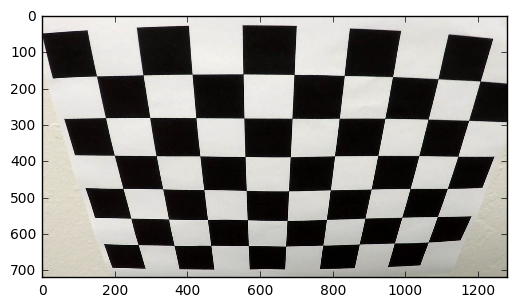

In [2]:
#Read in original image
image = mpimg.imread('camera_cal/calibration2.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

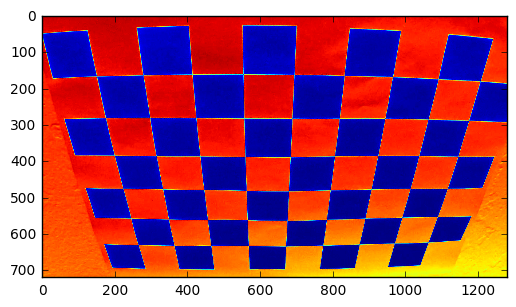

In [3]:
#grayscale the image
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(grayscale_image)

In [4]:
# Create object and image points based on chessboard images

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points 
imgpoints = [] # 2d points 

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [5]:
# Test undistortion on an image
fname = 'camera_cal/calibration3.jpg'
img = cv2.imread(fname)
print('This image is:', type(image), 'with dimesions:', image.shape)
img_size = (img.shape[1], img.shape[0])

# Camera calibration 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


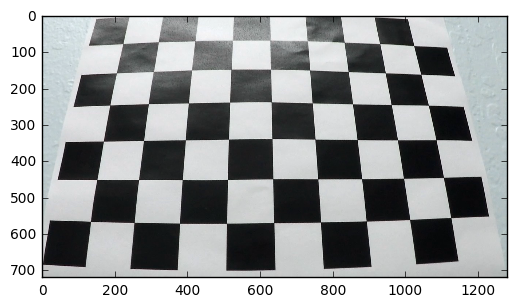

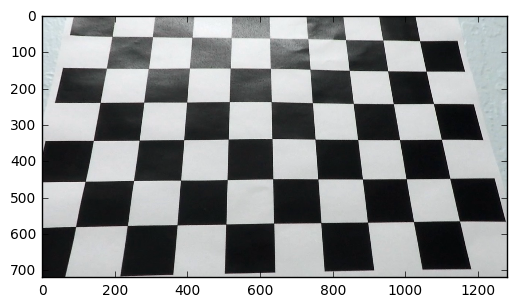

In [6]:
plt.imshow(img)
plt.show()
plt.imshow(dst)
plt.show()

In [7]:
# Test undistortion on a road image
img = cv2.imread('test_images/test1.jpg')
img = cv2.resize(img, (1280, 720))
dst_img = cv2.undistort(img, mtx, dist, None, mtx)

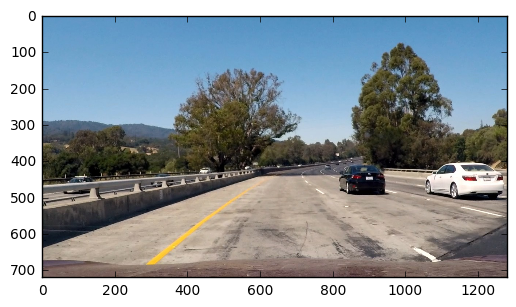

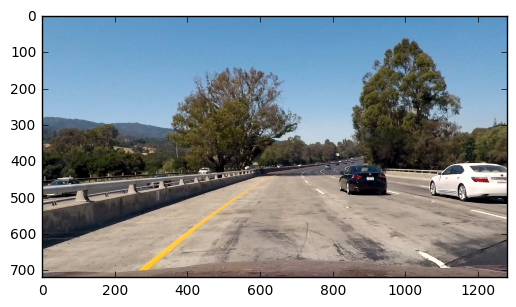

In [8]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
# Color transforms, gradients and color thresholding to create binary image
img = cv2.imread('test_images/test1.jpg')

def pipeline(img, l_thresh=(220, 255), sx_thresh=(60, 100), v_thresh=(220, 255)):
    img = np.copy(img)
    # Convert img to HSV color space, sort out l channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    # Take the derivative in x 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx) 
    #Convert the absolute value image to 8-bit
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float)
    v_channel = hsv[:, :, 2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    #v_binary[v_channel >= 220 and v_channel <= 255] = 1
    
    # Get threshold x gradient sxbinary
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Get threshold color channel l_binary 
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    # Stack and combine all 3 binary thresholds
    color_binary = np.dstack((l_binary, sxbinary, v_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (l_binary == 1) | (v_binary == 1)] = 1
    return combined_binary

# Pipeline image 
result = pipeline(img)

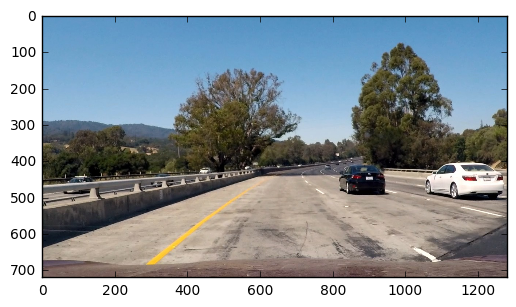

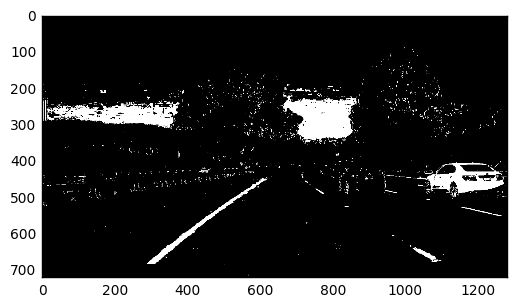

In [10]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(result, cmap="gray")
plt.show()

In [11]:
#Warp Images
src = np.float32([ [540, 450], [720, 450], [1280, 720], [0, 720] ])
img_size = [1280, 720]
dst = np.float32([ [100,0], [img_size[0]-100, 0], 
    [img_size[0]-100,img_size[1]], [100,img_size[1]] ])

In [12]:
def get_perspective_transform(img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    return M

In [13]:
def transform_perspective(img, M, dst_img_size):
    # Transform image to birds-eye-view
    warped = cv2.warpPerspective(img, M, dst_img_size)
    return warped

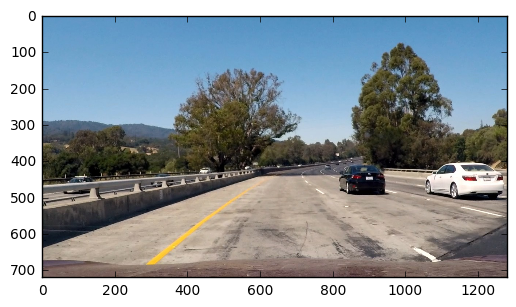

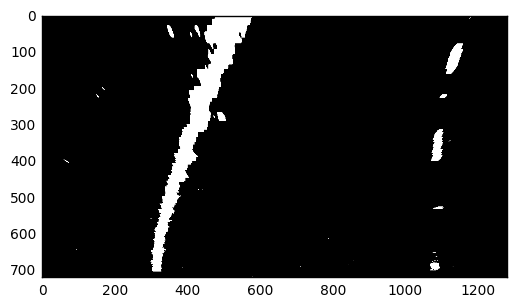

In [14]:
img = mpimg.imread('test_images/test1.jpg')
M = cv2.getPerspectiveTransform(src, dst)

# Resize image for consistency
img = cv2.resize(img, (1280,720))

#warped = transform_perspective(result, M, (1280, 720))
warped = transform_perspective(result, M, (1280, 720))
plt.imshow(img)
plt.show()
plt.imshow(warped, cmap="gray")
plt.show()

/Users/sunnyzhang/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


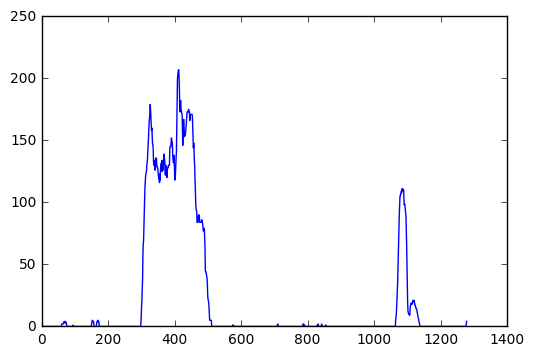

In [15]:
#Create Histogram to observe the peaks
histogram = np.sum(warped[warped.shape[0]/5:,:], axis=0)
plt.plot(histogram);

In [16]:
#Return x,y coordinates where pixel value is 1
def array_pixels(vertices):
    mask = np.zeros_like(warped)
    cv2.fillPoly(mask, [vertices], 255)
    masked_image = cv2.bitwise_and(warped, mask)
    pts = np.where(masked_image == 1)
    return pts

#masked_image[masked_image==1]

In [17]:
test_warped_image = np.array([[0,0], [0,300], [700,300], [600,0]])
test_points = array_pixels(test_warped_image)
print (test_points)
print (warped.shape)
print (img_size)

(array([  0,   0,   0, ..., 300, 300, 300]), array([475, 476, 477, ..., 452, 453, 454]))
(720, 1280)
[1280, 720]


In [18]:
def find_left_right_lanes(number_of_slices, warped, width_pixel):
    #number_of_slices = 5
    #width_pixel = 50
    x_left = []
    y_left = []
    x_right = []
    y_right = []
    
    for i in range(number_of_slices): 
        #sliding window y, 145 comes from 720 / 5, and 720 is the height of image
        bottom_y = 720 - np.int32(i * 145)
        top_y = 720 - np.int32(min(720, 145 * (i + 1) - 1))

        if i != 0:
            hist_left = np.sum(warped[top_y : bottom_y, np.int32(left_peak - width_pixel): np.int32(left_peak + width_pixel)], axis=0)
            left_peak = left_peak - width_pixel + np.argmax(hist_left)  
            hist_right = np.sum(warped[top_y : bottom_y, np.int32(right_peak - width_pixel): np.int32(right_peak + width_pixel)], axis=0)
            right_peak = right_peak - width_pixel + np.argmax(hist_right)

        else: 
            #480 comes from 720 x 2 / 3
            peak_histogram = np.sum(warped[480:,:], axis=0)
            #640 comes from 1280 / 2
            left_peak = np.argmax(peak_histogram[:640])
            #640 comes from 1280 / 2
            right_peak = 640 + np.argmax(peak_histogram[640:])

        left_vertices = np.int32([[left_peak - width_pixel, bottom_y], [left_peak - width_pixel, top_y], 
                         [left_peak + width_pixel, top_y], [left_peak + width_pixel, bottom_y]])

        right_vertices = np.int32([[right_peak - width_pixel, bottom_y], [right_peak - width_pixel, top_y], 
                         [right_peak + width_pixel, top_y], [right_peak + width_pixel, bottom_y]])

        left_pixels = array_pixels(left_vertices)
        right_pixels = array_pixels(right_vertices)

        x_left.extend(np.array(left_pixels[1]))
        y_left.extend(np.array(left_pixels[0]))
        x_right.extend(np.array(right_pixels[1]))
        y_right.extend(np.array(right_pixels[0]))
        
    return x_left, y_left, x_right, y_right

In [19]:
#Get pixels associated with lane lines from warped images
number_of_slices = 5
width_pixel = 50
x_left, y_left, x_right, y_right = find_left_right_lanes(number_of_slices, warped, width_pixel)

In [20]:
#Enhance polynomial curve
left_fit = np.polyfit(y_left, x_left, 2)
right_fit = np.polyfit(y_right, x_right, 2)
yvals = np.linspace(0, 100, num=99)* (720 / 100)
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

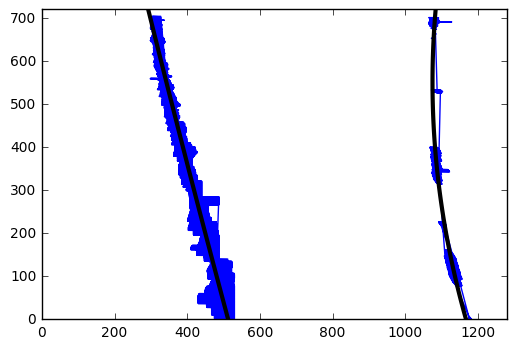

In [21]:
#Plot visualization
plt.plot(x_left, y_left, color='blue')
plt.plot(x_right, y_right, color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, yvals, color='black', linewidth=3)
plt.plot(right_fitx, yvals, color='black', linewidth=3)

In [22]:
#Create class line for image and video processing
class Line():
    def __init__(self):
        #Left line radius of curvature
        self.left_rad = 0
        #Right line radius of curvature
        self.right_rad = 0
        #Fitted left lines
        self.left_fitx = np.zeros([1, 101])
        #Fitted right lines
        self.right_fitx = np.zeros([1, 101])
        #Bottom part of image x marker left
        self.left_x_marker = 0
        #Bottom part of image x marker right
        self.right_x_marker = 0

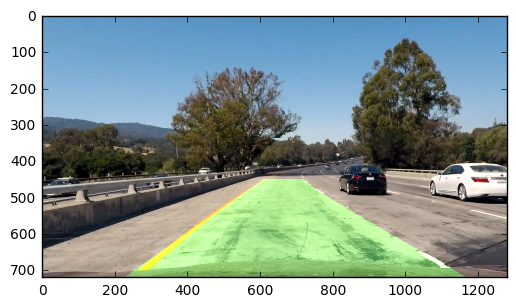

In [23]:
#Use np.zeros to create image with zeros
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

#Transform x and y points, use cv2.fillPoly to fill in green color 
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

#Use inverse perspective matrix, combine with original image
newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (img.shape[1], img.shape[0])) 
result_temp = cv2.addWeighted(dst_img, 1, newwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result_temp, cv2.COLOR_BGR2RGB));

In [24]:
def array_pixels_warped(vertices, warped):
    mask = np.zeros_like(warped)
    cv2.fillPoly(mask, [vertices], 255)
    masked_image = cv2.bitwise_and(warped, mask)
    pts = np.where(masked_image == 1)
    return pts

In [25]:
M = cv2.getPerspectiveTransform(src, dst)
img_size = (img.shape[1], img.shape[0])

def add_lane(image):
    number_of_slices = 5
    img = cv2.imread(image)
    img = cv2.resize(img, (1280, 720))
    width_pixel = 50

    #Remove distortation 
    dst_img = cv2.undistort(img, mtx, dist, None, mtx)

    #Get lane lines
    result = pipeline(dst_img)

    #Get warped image
    warped = cv2.warpPerspective(result, M, img_size)

    #Find lane lines
    x_left = []
    x_right = []
    y_left = []
    y_right = []
    
    for i in range(number_of_slices): 
        #sliding window y, 145 comes from 720 / 5, and 720 is the height of image
        bottom_y = 720 - np.int32(i * 145)
        top_y = 720 - np.int32(min(720, 145 * (i + 1) - 1))

        if i != 0:
            hist_left = np.sum(warped[top_y : bottom_y, np.int32(left_peak - width_pixel): np.int32(left_peak + width_pixel)], axis=0)
            left_peak = left_peak - width_pixel + np.argmax(hist_left)  
            hist_right = np.sum(warped[top_y : bottom_y, np.int32(right_peak - width_pixel): np.int32(right_peak + width_pixel)], axis=0)
            right_peak = right_peak - width_pixel + np.argmax(hist_right)

        else: 
            #480 comes from 720 x 2 / 3
            peak_histogram = np.sum(warped[480:,:], axis=0)
            #640 comes from 1280 / 2
            left_peak = np.argmax(peak_histogram[:640])
            #640 comes from 1280 / 2
            right_peak = 640 + np.argmax(peak_histogram[640:])

        left_vertices = np.int32([[left_peak - width_pixel, bottom_y], [left_peak - width_pixel, top_y], 
                         [left_peak + width_pixel, top_y], [left_peak + width_pixel, bottom_y]])

        right_vertices = np.int32([[right_peak - width_pixel, bottom_y], [right_peak - width_pixel, top_y], 
                         [right_peak + width_pixel, top_y], [right_peak + width_pixel, bottom_y]])


        left_pixels = array_pixels_warped(left_vertices, warped)
        right_pixels = array_pixels_warped(right_vertices, warped)

        x_left.extend(left_pixels[1])
        y_left.extend(left_pixels[0])
        x_right.extend(right_pixels[1])
        y_right.extend(right_pixels[0])
    
    x_left = np.array(x_left)
    y_left = np.array(y_left)
    x_right = np.array(x_right)
    y_right = np.array(y_right)
    
    #Enhance polynomial 
    left_fit = np.polyfit(y_left, x_left, 2)
    right_fit = np.polyfit(y_right, x_right, 2)
    
    yvals = np.linspace(0, 100, num=99)* (img_size[1] / 100)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    #same code as fill lane line pixels with green
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    image_with_lane = cv2.addWeighted(dst_img, 1, newwarp, 0.3, 0)
    
    return image_with_lane

In [26]:
#Video Processing
from moviepy.editor import VideoFileClip
from IPython.display import HTML
img_size = (img.shape[1], img.shape[0])
def add_lane_video(img):
     
    number_of_slices=5
    img = cv2.resize(img, (1280, 720))
    width_pixel = 50

    #Remove distortation 
    dst_img = cv2.undistort(img, mtx, dist, None, mtx)
    #Get lane lines
    result = pipeline(dst_img)
    #Get warped image
    warped = cv2.warpPerspective(result, M, img_size)
    
    #Find lane lines
    x_left = []
    x_right = []
    y_left = []
    y_right = []
    
    for i in range(number_of_slices): 
        #sliding window y, 145 comes from 720 / 5, and 720 is the height of image
        bottom_y = 720 - np.int32(i * 145)
        top_y = 720 - np.int32(min(720, 145 * (i + 1) - 1))

        if i != 0:
            hist_left = np.sum(warped[top_y : bottom_y, np.int32(left_peak - width_pixel): np.int32(left_peak + width_pixel)], axis=0)
            left_peak = left_peak - width_pixel + np.argmax(hist_left)  
            hist_right = np.sum(warped[top_y : bottom_y, np.int32(right_peak - width_pixel): np.int32(right_peak + width_pixel)], axis=0)
            right_peak = right_peak - width_pixel + np.argmax(hist_right)

        else: 
            #480 comes from 720 x 2 / 3
            peak_histogram = np.sum(warped[480:,:], axis=0)
            #640 comes from 1280 / 2
            left_peak = np.argmax(peak_histogram[:640])
            #640 comes from 1280 / 2
            right_peak = 640 + np.argmax(peak_histogram[640:])

        left_vertices = np.int32([[left_peak - width_pixel, bottom_y], [left_peak - width_pixel, top_y], 
                         [left_peak + width_pixel, top_y], [left_peak + width_pixel, bottom_y]])

        right_vertices = np.int32([[right_peak - width_pixel, bottom_y], [right_peak - width_pixel, top_y], 
                         [right_peak + width_pixel, top_y], [right_peak + width_pixel, bottom_y]])

        left_pixels = array_pixels_warped(left_vertices, warped)
        right_pixels = array_pixels_warped(right_vertices, warped)

        x_left.extend(left_pixels[1])
        y_left.extend(left_pixels[0])
        x_right.extend(right_pixels[1])
        y_right.extend(right_pixels[0])
    
    x_left = np.array(x_left)
    y_left = np.array(y_left)
    x_right = np.array(x_right)
    y_right = np.array(y_right)

    left_fit = np.polyfit(y_left, x_left, 2)
    right_fit = np.polyfit(y_right, x_right, 2)
    
    yvals = np.linspace(0, 100, num=101)* (img_size[1] / 100)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    ym_per_pix = 0.04 
    xm_per_pix = 0.004 
    y_eval = np.max(yvals)

    left_fit_cr = np.polyfit(y_left*ym_per_pix, x_left*xm_per_pix, 2)
    right_fit_cr = np.polyfit(y_right*ym_per_pix, x_right*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    #Initial conditions 
    if last_line.left_rad == 0:
        #Initial curves and fits for right and left line
        last_line.left_rad = left_curverad
        last_line.right_rad = right_curverad
        last_line.left_fitx[0] = left_fitx
        last_line.right_fitx[0] = right_fitx
        
        #Initial lane positions
        last_line.left_x_marker = left_fitx[100]
        last_line.right_x_marker = right_fitx[100]
        
        #Initial position as the center of lane
        center_of_lane = (right_fitx[100] - left_fitx[100]) / 2
        last_line.line_base_pos = center_of_lane
        
    else:
        
        #Left curvature difference 
        leftcurve_diff = (left_curverad - last_line.left_rad) / last_line.left_rad
        
        if abs(leftcurve_diff) > 0.5:
            left_fitx = last_line.left_fitx[0]
            left_curverad = last_line.left_rad
        
        elif abs(left_fitx[100] - last_line.left_x_marker) > 75:
            left_fitx = last_line.left_fitx[0]
            left_curverad = last_line.left_rad
            
        else:
            last_line.left_rad = left_curverad
            last_line.left_fitx[0] = left_fitx
        
        #Right curvature difference
        rightcurve_diff = (right_curverad - last_line.right_rad) / last_line.right_rad

        if abs(rightcurve_diff) > 0.5:
            right_fitx = last_line.right_fitx[0]
            right_curverad = last_line.right_rad
        
        elif abs(right_fitx[100] - last_line.right_x_marker) > 75:
            right_fitx = last_line.right_fitx[0]
            right_curverad = last_line.right_rad
            
        else: 
            last_line.right_rad = right_curverad
            last_line.right_fitx[0] = right_fitx 
            
    #Determine average radius of curvature
    curve_rad = (left_curverad + right_curverad) / 2
    print(left_curverad, right_curverad)

    #Distance measurement
    car_center = 640
    center_of_lane = (right_fitx[100] - left_fitx[100]) / 2
    distance_from_center = (car_center - center_of_lane) * xm_per_pix
    
    if distance_from_center <= 0:
        side = "left"
    else:
        side = "right"
    
    #same code as the image processing
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (img.shape[1], img.shape[0])) 
    
    image_with_lane = cv2.addWeighted(dst_img, 1, newwarp, 0.3, 0)
    
    # Add text with radius of curvature and distance from center
    font = cv2.FONT_HERSHEY_SIMPLEX
    rad_curve_text = "Radius of curvature: %.2f m" % curve_rad
    center_text = "Distance from center: %.2f m %s" % (abs(distance_from_center), side)
    cv2.putText(image_with_lane, rad_curve_text,(10,30), font, 0.8,(255,255,255),2)
    cv2.putText(image_with_lane, center_text,(10,60), font, 0.8,(255,255,255),2)
    
    return image_with_lane

In [27]:
last_line = Line()
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
road_clip = clip1.fl_image(add_lane_video)
%time road_clip.write_videofile(video_output, audio=False)

2605.11177482 1904.44505599
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 1/1261 [00:00<06:40,  3.15it/s]

2605.11177482 1904.44505599


  0%|          | 2/1261 [00:00<07:04,  2.97it/s]

2623.52945356 1755.83449764


  0%|          | 3/1261 [00:01<07:20,  2.86it/s]

2721.19433864 1958.76172572


  0%|          | 4/1261 [00:01<07:26,  2.82it/s]

2670.01582013 1821.17002841


  0%|          | 5/1261 [00:01<07:41,  2.72it/s]

2587.85610533 1804.21239269


  0%|          | 6/1261 [00:02<07:33,  2.77it/s]

2548.86674613 1748.57935397


  1%|          | 7/1261 [00:02<08:37,  2.42it/s]

2617.74658406 1850.09787515


  1%|          | 8/1261 [00:03<08:32,  2.44it/s]

2503.35685291 2001.45272034


  1%|          | 9/1261 [00:03<07:56,  2.63it/s]

2276.17539887 1747.07603016


  1%|          | 10/1261 [00:03<07:23,  2.82it/s]

2345.29317829 1851.42787818


  1%|          | 11/1261 [00:04<06:58,  2.98it/s]

2250.47556242 1748.63915675


  1%|          | 12/1261 [00:04<06:57,  2.99it/s]

2054.88410321 2131.88873188


  1%|          | 13/1261 [00:04<06:50,  3.04it/s]

2163.24185457 1787.44756769


  1%|          | 14/1261 [00:04<06:48,  3.05it/s]

2076.17053192 1762.70920407


  1%|          | 15/1261 [00:05<06:36,  3.14it/s]

2110.66255032 1793.85256115


  1%|▏         | 16/1261 [00:05<06:44,  3.08it/s]

2318.30115478 1753.58953704


  1%|▏         | 17/1261 [00:05<06:57,  2.98it/s]

2275.57381765 1777.07550145


  1%|▏         | 18/1261 [00:06<06:37,  3.13it/s]

2160.2759988 2421.95922615


  2%|▏         | 19/1261 [00:06<06:33,  3.16it/s]

2079.30305875 1745.75083505


  2%|▏         | 20/1261 [00:06<06:35,  3.14it/s]

2107.47854815 1739.62702701


  2%|▏         | 21/1261 [00:07<06:24,  3.23it/s]

2012.68882316 1893.94914321


  2%|▏         | 22/1261 [00:07<06:18,  3.27it/s]

1948.09371499 1750.58475105


  2%|▏         | 23/1261 [00:07<06:20,  3.25it/s]

1893.4916286 1881.70288167


  2%|▏         | 24/1261 [00:08<06:26,  3.20it/s]

1949.32252965 1789.69688613


  2%|▏         | 25/1261 [00:08<06:28,  3.18it/s]

2058.1615589 1915.3965834


  2%|▏         | 26/1261 [00:08<06:36,  3.11it/s]

2046.41043459 1788.95812849


  2%|▏         | 27/1261 [00:09<06:25,  3.20it/s]

2133.39767064 1811.86506217


  2%|▏         | 28/1261 [00:09<06:18,  3.26it/s]

2131.34890276 1974.19117522


  2%|▏         | 29/1261 [00:09<06:16,  3.27it/s]

2261.14794771 1972.58821899


  2%|▏         | 30/1261 [00:09<06:13,  3.30it/s]

2606.28717267 1959.73465807


  2%|▏         | 31/1261 [00:10<06:09,  3.33it/s]

2761.52241008 1789.36947307


  3%|▎         | 32/1261 [00:10<06:12,  3.30it/s]

2998.22030528 1745.60489142


  3%|▎         | 33/1261 [00:10<06:16,  3.26it/s]

2911.70359012 1819.86738629


  3%|▎         | 34/1261 [00:11<06:17,  3.25it/s]

3069.25371813 1762.81885688


  3%|▎         | 35/1261 [00:11<06:26,  3.17it/s]

3455.14454743 1855.68695031


  3%|▎         | 36/1261 [00:12<09:26,  2.16it/s]

3447.07910705 1898.70787639


  3%|▎         | 37/1261 [00:13<11:55,  1.71it/s]

3262.9617762 2107.4683846


  3%|▎         | 38/1261 [00:13<11:56,  1.71it/s]

3391.25380254 2217.83087606


  3%|▎         | 39/1261 [00:14<10:44,  1.90it/s]

3560.27649675 1836.01427768


  3%|▎         | 40/1261 [00:14<09:48,  2.07it/s]

3619.64008169 1792.68277217


  3%|▎         | 41/1261 [00:14<09:11,  2.21it/s]

3483.96063789 2031.99023988


  3%|▎         | 42/1261 [00:15<08:22,  2.43it/s]

3444.13895787 1974.11775835


  3%|▎         | 43/1261 [00:15<08:01,  2.53it/s]

3267.38222506 1982.63529549


  3%|▎         | 44/1261 [00:15<07:33,  2.68it/s]

3131.92028802 1903.01852054


  4%|▎         | 45/1261 [00:16<07:17,  2.78it/s]

2944.00929994 1864.28045331


  4%|▎         | 46/1261 [00:16<08:36,  2.35it/s]

2806.9385321 1735.57297839


  4%|▎         | 47/1261 [00:17<08:16,  2.44it/s]

2791.17761058 1893.03001927


  4%|▍         | 48/1261 [00:17<08:06,  2.49it/s]

2622.24941651 2023.74982309


  4%|▍         | 49/1261 [00:17<07:55,  2.55it/s]

2401.95125114 1958.47320376


  4%|▍         | 50/1261 [00:18<09:12,  2.19it/s]

2303.07367936 2126.70627368


  4%|▍         | 51/1261 [00:18<08:44,  2.31it/s]

2206.3148941 1963.22309224


  4%|▍         | 52/1261 [00:19<08:10,  2.47it/s]

2207.12254505 1916.03819134


  4%|▍         | 53/1261 [00:19<07:42,  2.61it/s]

2154.74745369 2014.93779276


  4%|▍         | 54/1261 [00:19<07:29,  2.68it/s]

2173.9103816 2123.40580332


  4%|▍         | 55/1261 [00:20<07:12,  2.79it/s]

2114.93655475 1943.74609671


  4%|▍         | 56/1261 [00:20<07:06,  2.83it/s]

2070.22605845 1778.35577511


  5%|▍         | 57/1261 [00:20<06:54,  2.91it/s]

2061.35350289 1738.17078253


  5%|▍         | 58/1261 [00:21<06:50,  2.93it/s]

2009.20422163 1795.47750398


  5%|▍         | 59/1261 [00:21<06:43,  2.98it/s]

2064.98939448 1796.45277003


  5%|▍         | 60/1261 [00:22<07:09,  2.79it/s]

2129.9848729 1779.6755129


  5%|▍         | 61/1261 [00:22<07:34,  2.64it/s]

2161.90473917 1774.0551965


  5%|▍         | 62/1261 [00:22<07:44,  2.58it/s]

2295.98322194 1879.39446079


  5%|▍         | 63/1261 [00:23<08:12,  2.43it/s]

2148.28955304 1871.41354264


  5%|▌         | 64/1261 [00:23<08:39,  2.30it/s]

2187.03378588 1841.30965562


  5%|▌         | 65/1261 [00:24<09:06,  2.19it/s]

2200.45097886 1792.12636338


  5%|▌         | 66/1261 [00:24<09:13,  2.16it/s]

2257.97676291 1841.91692222


  5%|▌         | 67/1261 [00:25<08:55,  2.23it/s]

2170.33442646 1945.53826447


  5%|▌         | 68/1261 [00:25<08:37,  2.30it/s]

2211.04870125 2372.43042283


  5%|▌         | 69/1261 [00:25<08:12,  2.42it/s]

2276.97204412 1752.65530919


  6%|▌         | 70/1261 [00:26<07:42,  2.58it/s]

2117.72341625 1736.530943


  6%|▌         | 71/1261 [00:26<07:38,  2.60it/s]

2144.97459761 1854.31426112


  6%|▌         | 72/1261 [00:27<07:27,  2.66it/s]

2095.06336464 2107.43942781


  6%|▌         | 73/1261 [00:27<07:14,  2.74it/s]

2014.92948313 2007.87132597


  6%|▌         | 74/1261 [00:27<07:23,  2.68it/s]

1941.37659107 1900.85676525


  6%|▌         | 75/1261 [00:28<07:10,  2.75it/s]

1893.8653569 2124.64058633


  6%|▌         | 76/1261 [00:28<07:01,  2.81it/s]

1910.49101565 2393.89473137


  6%|▌         | 77/1261 [00:28<07:12,  2.74it/s]

1832.96529759 2229.37919946


  6%|▌         | 78/1261 [00:29<07:07,  2.77it/s]

1830.33989748 2461.7413687


  6%|▋         | 79/1261 [00:29<07:07,  2.76it/s]

1829.27567904 2242.32311346


  6%|▋         | 80/1261 [00:29<07:17,  2.70it/s]

1829.02853481 2020.55733285


  6%|▋         | 81/1261 [00:30<07:33,  2.60it/s]

1835.65077347 1952.87633494


  7%|▋         | 82/1261 [00:30<07:49,  2.51it/s]

1844.97065009 1930.82823188


  7%|▋         | 83/1261 [00:31<07:49,  2.51it/s]

1872.6895104 1979.68807721


  7%|▋         | 84/1261 [00:31<07:33,  2.60it/s]

1869.39792454 1750.80265067


  7%|▋         | 85/1261 [00:31<07:14,  2.71it/s]

1892.17756845 1756.11067752


  7%|▋         | 86/1261 [00:32<07:06,  2.76it/s]

1939.03093032 1751.47580978


  7%|▋         | 87/1261 [00:32<08:20,  2.34it/s]

2158.75089013 1769.57372665


  7%|▋         | 88/1261 [00:33<07:53,  2.48it/s]

2229.71729641 1751.56456335


  7%|▋         | 89/1261 [00:33<07:28,  2.62it/s]

2345.91358599 1846.82748923


  7%|▋         | 90/1261 [00:33<07:10,  2.72it/s]

2598.59830295 1992.71533476


  7%|▋         | 91/1261 [00:34<06:52,  2.84it/s]

2626.13221591 1967.79445565


  7%|▋         | 92/1261 [00:34<06:54,  2.82it/s]

2522.91852791 1806.69900006


  7%|▋         | 93/1261 [00:34<07:17,  2.67it/s]

2731.26144171 1842.57986184


  7%|▋         | 94/1261 [00:35<07:01,  2.77it/s]

2751.61603591 1896.18697427


  8%|▊         | 95/1261 [00:35<06:45,  2.87it/s]

2655.93806038 1861.20175966


  8%|▊         | 96/1261 [00:35<06:56,  2.79it/s]

2715.12491637 1801.55623881


  8%|▊         | 97/1261 [00:36<06:45,  2.87it/s]

2683.74034868 1977.51699939


  8%|▊         | 98/1261 [00:36<06:40,  2.90it/s]

2609.57007205 2174.02302388


  8%|▊         | 99/1261 [00:36<06:38,  2.92it/s]

2668.45875867 2130.41663917


  8%|▊         | 100/1261 [00:37<06:28,  2.99it/s]

2604.88399029 2214.66403988


  8%|▊         | 101/1261 [00:37<06:24,  3.02it/s]

2673.64609468 2198.14952439


  8%|▊         | 102/1261 [00:37<06:22,  3.03it/s]

2738.31848772 2060.3822029


  8%|▊         | 103/1261 [00:38<06:09,  3.13it/s]

2708.93539478 2600.23929802


  8%|▊         | 104/1261 [00:38<06:05,  3.16it/s]

2723.81016989 2241.85937153


  8%|▊         | 105/1261 [00:38<06:12,  3.11it/s]

2522.31496348 1902.30334183


  8%|▊         | 106/1261 [00:39<06:09,  3.13it/s]

2629.6633312 2173.05051299


  8%|▊         | 107/1261 [00:39<06:18,  3.05it/s]

2558.74944822 1905.17636037


  9%|▊         | 108/1261 [00:39<06:20,  3.03it/s]

2703.23960725 2131.32512655


  9%|▊         | 109/1261 [00:40<06:28,  2.97it/s]

2672.75860752 2090.86762575


  9%|▊         | 110/1261 [00:40<06:29,  2.96it/s]

2605.19607057 2484.82341434


  9%|▉         | 111/1261 [00:40<06:28,  2.96it/s]

2639.56207947 2304.84391413


  9%|▉         | 112/1261 [00:41<06:15,  3.06it/s]

2503.1518803 2098.41345432


  9%|▉         | 113/1261 [00:41<06:09,  3.11it/s]

2893.22958356 1969.48181404


  9%|▉         | 114/1261 [00:41<06:05,  3.14it/s]

2740.95224832 1927.27195631


  9%|▉         | 115/1261 [00:42<06:01,  3.17it/s]

3007.99980697 2622.34197406


  9%|▉         | 116/1261 [00:42<05:53,  3.23it/s]

3023.98482074 2814.93130468


  9%|▉         | 117/1261 [00:42<06:04,  3.14it/s]

3002.53914014 2477.9234059


  9%|▉         | 118/1261 [00:43<05:57,  3.19it/s]

3104.82569911 2284.25013405


  9%|▉         | 119/1261 [00:43<05:57,  3.19it/s]

3085.95332848 2062.97346193


 10%|▉         | 120/1261 [00:43<05:53,  3.23it/s]

3317.75916723 2139.26448457


 10%|▉         | 121/1261 [00:43<05:53,  3.22it/s]

3122.36457616 2653.36438919


 10%|▉         | 122/1261 [00:44<05:56,  3.19it/s]

3079.14234439 2414.47749713


 10%|▉         | 123/1261 [00:44<05:58,  3.17it/s]

3287.82013102 3616.92122962


 10%|▉         | 124/1261 [00:44<06:03,  3.13it/s]

3099.64814812 2632.06553616


 10%|▉         | 125/1261 [00:45<05:59,  3.16it/s]

3063.46391498 2929.98253137


 10%|▉         | 126/1261 [00:45<05:53,  3.21it/s]

2765.9902966 3436.44275472


 10%|█         | 127/1261 [00:45<05:57,  3.17it/s]

2893.47246815 2046.50614708


 10%|█         | 128/1261 [00:46<05:51,  3.22it/s]

2614.91891541 2397.5193117


 10%|█         | 129/1261 [00:46<05:47,  3.26it/s]

2845.76224923 2468.42023782


 10%|█         | 130/1261 [00:46<05:57,  3.17it/s]

2652.41420947 1922.25392259


 10%|█         | 131/1261 [00:47<06:14,  3.01it/s]

2611.45928907 1884.89492288


 10%|█         | 132/1261 [00:47<06:18,  2.98it/s]

2558.00104092 1982.6041626


 11%|█         | 133/1261 [00:47<06:08,  3.06it/s]

2566.59441536 2313.46916264


 11%|█         | 134/1261 [00:48<06:06,  3.07it/s]

2415.53617461 2189.51904526


 11%|█         | 135/1261 [00:48<06:05,  3.08it/s]

2353.3180703 1742.87754608


 11%|█         | 136/1261 [00:48<06:14,  3.01it/s]

2214.87150901 1920.28331508


 11%|█         | 137/1261 [00:49<06:28,  2.89it/s]

2214.58188878 1810.27325575


 11%|█         | 138/1261 [00:49<06:28,  2.89it/s]

2156.85459499 1825.29425222


 11%|█         | 139/1261 [00:49<06:32,  2.86it/s]

2085.38844888 1785.85168786


 11%|█         | 140/1261 [00:50<06:28,  2.88it/s]

2020.74804493 1754.87491154


 11%|█         | 141/1261 [00:50<06:20,  2.94it/s]

2050.07170747 1756.94962762


 11%|█▏        | 142/1261 [00:50<06:31,  2.86it/s]

2065.36394842 1844.40099298


 11%|█▏        | 143/1261 [00:51<06:31,  2.85it/s]

2188.99296592 1747.77275125


 11%|█▏        | 144/1261 [00:51<06:16,  2.96it/s]

2175.47429879 1877.98352968


 11%|█▏        | 145/1261 [00:51<06:05,  3.05it/s]

2122.0637769 1832.50537487


 12%|█▏        | 146/1261 [00:52<06:21,  2.92it/s]

2195.73424029 1810.78560115


 12%|█▏        | 147/1261 [00:52<07:04,  2.62it/s]

2118.87937771 1749.99001579


 12%|█▏        | 148/1261 [00:53<06:57,  2.67it/s]

2296.93026353 2037.90498984


 12%|█▏        | 149/1261 [00:53<07:03,  2.63it/s]

2279.34875707 2161.11994142


 12%|█▏        | 150/1261 [00:53<06:59,  2.65it/s]

2293.02321594 1959.10436194


 12%|█▏        | 151/1261 [00:54<06:45,  2.74it/s]

2232.30536194 2650.91785916


 12%|█▏        | 152/1261 [00:54<07:08,  2.59it/s]

2112.53888585 1933.32528465


 12%|█▏        | 153/1261 [00:55<07:21,  2.51it/s]

2215.15531026 2182.84293481


 12%|█▏        | 154/1261 [00:55<07:09,  2.57it/s]

2158.58361075 2039.47639458


 12%|█▏        | 155/1261 [00:55<06:57,  2.65it/s]

2166.47131681 1949.69422464


 12%|█▏        | 156/1261 [00:56<06:44,  2.73it/s]

2198.44474552 1798.17003805


 12%|█▏        | 157/1261 [00:56<06:25,  2.86it/s]

2206.920286 1768.81150864


 13%|█▎        | 158/1261 [00:56<06:26,  2.85it/s]

2350.39440787 2175.12016876


 13%|█▎        | 159/1261 [00:57<06:21,  2.89it/s]

2414.53750656 1733.15266439


 13%|█▎        | 160/1261 [00:57<06:13,  2.94it/s]

2427.87854706 1805.32976681


 13%|█▎        | 161/1261 [00:57<06:03,  3.03it/s]

2497.32155469 1736.19384239


 13%|█▎        | 162/1261 [00:58<05:53,  3.11it/s]

2366.29879647 1845.46676433


 13%|█▎        | 163/1261 [00:58<05:49,  3.14it/s]

2346.08584418 1840.35414085


 13%|█▎        | 164/1261 [00:58<05:53,  3.11it/s]

2466.37708698 2035.08500328


 13%|█▎        | 165/1261 [00:59<05:56,  3.07it/s]

2515.28554192 2035.08500328


 13%|█▎        | 166/1261 [00:59<05:51,  3.12it/s]

2583.08152387 1855.30412539


 13%|█▎        | 167/1261 [00:59<05:51,  3.11it/s]

2518.63971034 1826.41826846


 13%|█▎        | 168/1261 [01:00<05:49,  3.12it/s]

2374.64023286 1913.23339873


 13%|█▎        | 169/1261 [01:00<05:47,  3.15it/s]

2385.27761186 1757.98632855


 13%|█▎        | 170/1261 [01:00<05:56,  3.06it/s]

2244.86729668 2474.14678953


 14%|█▎        | 171/1261 [01:00<05:58,  3.04it/s]

2191.63612281 1856.55568497


 14%|█▎        | 172/1261 [01:01<05:52,  3.09it/s]

2235.8148139 2302.97021654


 14%|█▎        | 173/1261 [01:01<05:48,  3.12it/s]

2271.54900434 3048.19740462


 14%|█▍        | 174/1261 [01:01<05:35,  3.24it/s]

2567.05065474 2563.57208907


 14%|█▍        | 175/1261 [01:02<05:35,  3.23it/s]

2587.31809265 2939.85477786


 14%|█▍        | 176/1261 [01:02<05:34,  3.24it/s]

2703.67947488 3180.05655224


 14%|█▍        | 177/1261 [01:02<05:50,  3.10it/s]

2473.72033347 3136.16829569


 14%|█▍        | 178/1261 [01:03<05:47,  3.12it/s]

2576.00144669 3883.48199194


 14%|█▍        | 179/1261 [01:03<05:45,  3.13it/s]

2611.11295427 3546.65879916


 14%|█▍        | 180/1261 [01:03<05:40,  3.17it/s]

2543.54401911 3521.65820314


 14%|█▍        | 181/1261 [01:04<05:35,  3.22it/s]

2794.99693255 3386.25481364


 14%|█▍        | 182/1261 [01:04<05:35,  3.22it/s]

2998.66607135 2803.41409276


 15%|█▍        | 183/1261 [01:04<05:42,  3.15it/s]

3267.38682981 3156.68062924


 15%|█▍        | 184/1261 [01:05<05:36,  3.20it/s]

3375.42894282 3618.21135172


 15%|█▍        | 185/1261 [01:05<05:34,  3.21it/s]

3593.61061296 3768.7384384


 15%|█▍        | 186/1261 [01:05<05:35,  3.20it/s]

4165.63956147 4077.87263505


 15%|█▍        | 187/1261 [01:05<05:35,  3.20it/s]

4028.01510546 3190.60321576


 15%|█▍        | 188/1261 [01:06<05:32,  3.22it/s]

4181.8420373 2320.52862395


 15%|█▍        | 189/1261 [01:06<05:39,  3.16it/s]

4203.71801761 1747.29640862


 15%|█▌        | 190/1261 [01:06<05:43,  3.11it/s]

4031.90815898 1780.99216086


 15%|█▌        | 191/1261 [01:07<05:41,  3.13it/s]

4212.04601807 2262.69058379


 15%|█▌        | 192/1261 [01:07<05:40,  3.14it/s]

3757.13348443 1895.94849561


 15%|█▌        | 193/1261 [01:07<05:36,  3.18it/s]

3766.42610789 2014.96796048


 15%|█▌        | 194/1261 [01:08<05:37,  3.16it/s]

3620.09500715 1923.77210018


 15%|█▌        | 195/1261 [01:08<05:36,  3.17it/s]

3555.94309467 1964.68733807


 16%|█▌        | 196/1261 [01:08<05:39,  3.13it/s]

2988.05279165 2298.85220607


 16%|█▌        | 197/1261 [01:09<05:42,  3.11it/s]

2660.25926282 1906.07448981


 16%|█▌        | 198/1261 [01:09<05:36,  3.15it/s]

2337.8627371 2003.80063576


 16%|█▌        | 199/1261 [01:09<05:32,  3.19it/s]

2222.34926702 1879.22603144


 16%|█▌        | 200/1261 [01:10<05:30,  3.21it/s]

2270.88201637 1994.63492311


 16%|█▌        | 201/1261 [01:10<05:33,  3.18it/s]

2210.23716338 1748.93677523


 16%|█▌        | 202/1261 [01:10<06:13,  2.83it/s]

2310.21451293 2040.51590351


 16%|█▌        | 203/1261 [01:11<06:02,  2.92it/s]

2452.99496671 1984.13063261


 16%|█▌        | 204/1261 [01:11<05:53,  2.99it/s]

2415.03362793 2282.8618242


 16%|█▋        | 205/1261 [01:11<05:55,  2.97it/s]

2642.70519915 2178.11151823


 16%|█▋        | 206/1261 [01:12<05:53,  2.98it/s]

2689.27167016 1905.19133926


 16%|█▋        | 207/1261 [01:12<05:45,  3.05it/s]

3072.44663386 1820.41173638


 16%|█▋        | 208/1261 [01:12<05:50,  3.00it/s]

3125.48116744 2305.61353705


 17%|█▋        | 209/1261 [01:13<05:45,  3.05it/s]

2996.83222606 2414.9809966


 17%|█▋        | 210/1261 [01:13<05:41,  3.07it/s]

2887.29152038 2224.44979465


 17%|█▋        | 211/1261 [01:13<05:33,  3.15it/s]

2782.49866403 2233.08562803


 17%|█▋        | 212/1261 [01:14<05:31,  3.16it/s]

2727.03428788 2518.84950664


 17%|█▋        | 213/1261 [01:14<05:29,  3.18it/s]

2708.3873977 3534.77634794


 17%|█▋        | 214/1261 [01:14<05:35,  3.12it/s]

2815.63921048 1779.15706758


 17%|█▋        | 215/1261 [01:15<05:35,  3.12it/s]

2852.7007783 1814.68115425


 17%|█▋        | 216/1261 [01:15<05:27,  3.19it/s]

2808.24923014 1917.74434234


 17%|█▋        | 217/1261 [01:15<05:20,  3.26it/s]

2889.77478037 1847.79628599


 17%|█▋        | 218/1261 [01:15<05:22,  3.24it/s]

2673.06486617 1808.82598665


 17%|█▋        | 219/1261 [01:16<05:18,  3.27it/s]

2659.41548121 1740.64736863


 17%|█▋        | 220/1261 [01:16<05:23,  3.22it/s]

2510.83645388 1828.27971435


 18%|█▊        | 221/1261 [01:16<05:26,  3.18it/s]

2411.39397012 1924.15833373


 18%|█▊        | 222/1261 [01:17<05:22,  3.23it/s]

2341.86917865 1757.17902818


 18%|█▊        | 223/1261 [01:17<05:18,  3.26it/s]

2283.94244274 1746.16536366


 18%|█▊        | 224/1261 [01:17<05:21,  3.23it/s]

2301.8874623 1803.59907332


 18%|█▊        | 225/1261 [01:18<05:27,  3.17it/s]

2254.31502979 1762.69594387


 18%|█▊        | 226/1261 [01:18<05:24,  3.19it/s]

2318.98289307 1735.49085798


 18%|█▊        | 227/1261 [01:18<05:33,  3.10it/s]

2207.9727593 1814.21374218


 18%|█▊        | 228/1261 [01:19<05:27,  3.15it/s]

2124.35566286 1948.9592015


 18%|█▊        | 229/1261 [01:19<05:22,  3.20it/s]

2149.62427625 1769.52247441


 18%|█▊        | 230/1261 [01:19<05:23,  3.19it/s]

2039.24187539 1796.25237637


 18%|█▊        | 231/1261 [01:20<05:23,  3.19it/s]

2173.17294956 1894.9755766


 18%|█▊        | 232/1261 [01:20<05:21,  3.20it/s]

2073.29782204 1909.1038295


 18%|█▊        | 233/1261 [01:20<05:29,  3.12it/s]

2118.46384863 1909.1038295


 19%|█▊        | 234/1261 [01:21<05:33,  3.08it/s]

2170.27022915 2381.16237603


 19%|█▊        | 235/1261 [01:21<05:35,  3.06it/s]

2182.03669638 2007.68690483


 19%|█▊        | 236/1261 [01:21<05:27,  3.13it/s]

2311.87521827 2434.77931641


 19%|█▉        | 237/1261 [01:21<05:30,  3.09it/s]

2343.32820848 2950.17478805


 19%|█▉        | 238/1261 [01:22<05:28,  3.12it/s]

2437.59273408 2416.34916702


 19%|█▉        | 239/1261 [01:22<05:30,  3.09it/s]

2526.05795325 2725.76702942


 19%|█▉        | 240/1261 [01:22<05:31,  3.08it/s]

2501.91080622 2906.70551416


 19%|█▉        | 241/1261 [01:23<05:30,  3.09it/s]

2411.7282658 2450.80588574


 19%|█▉        | 242/1261 [01:23<06:04,  2.79it/s]

2391.63434269 2248.60878458


 19%|█▉        | 243/1261 [01:24<05:49,  2.91it/s]

2621.40437615 2532.26463941


 19%|█▉        | 244/1261 [01:24<05:35,  3.03it/s]

2529.93769255 2586.00635962


 19%|█▉        | 245/1261 [01:24<05:32,  3.06it/s]

2577.71226783 2586.00635962


 20%|█▉        | 246/1261 [01:24<05:27,  3.10it/s]

2558.83621515 2580.411035


 20%|█▉        | 247/1261 [01:25<05:23,  3.13it/s]

2552.85624939 2453.09378598


 20%|█▉        | 248/1261 [01:25<05:45,  2.93it/s]

2700.73566087 2732.48937188


 20%|█▉        | 249/1261 [01:25<05:37,  2.99it/s]

2485.73816434 2319.38459958


 20%|█▉        | 250/1261 [01:26<05:28,  3.08it/s]

2383.65629603 2133.98048165


 20%|█▉        | 251/1261 [01:26<05:26,  3.10it/s]

2408.26856273 2532.56511742


 20%|█▉        | 252/1261 [01:26<05:33,  3.02it/s]

2376.68455163 2471.84391706


 20%|██        | 253/1261 [01:27<05:31,  3.04it/s]

2292.48654499 2161.1703004


 20%|██        | 254/1261 [01:27<05:28,  3.07it/s]

2276.11116682 1909.62217362


 20%|██        | 255/1261 [01:27<05:20,  3.14it/s]

2313.6659532 2015.12838086


 20%|██        | 256/1261 [01:28<05:20,  3.14it/s]

2341.39763327 2005.54028787


 20%|██        | 257/1261 [01:28<05:19,  3.14it/s]

2382.04402541 2038.78306907


 20%|██        | 258/1261 [01:28<05:24,  3.09it/s]

2441.8170168 2324.23332962


 21%|██        | 259/1261 [01:29<05:18,  3.15it/s]

2312.42644968 2431.80698468


 21%|██        | 260/1261 [01:29<05:12,  3.20it/s]

2345.89539143 2266.0168864


 21%|██        | 261/1261 [01:29<05:14,  3.18it/s]

2249.51689097 2083.62132411


 21%|██        | 262/1261 [01:30<05:18,  3.13it/s]

2292.02002238 2000.07648208


 21%|██        | 263/1261 [01:30<05:33,  2.99it/s]

2282.3453984 2827.20722925


 21%|██        | 264/1261 [01:30<05:59,  2.77it/s]

2214.32155212 2542.54320806


 21%|██        | 265/1261 [01:31<06:04,  2.74it/s]

2198.90547051 2077.60042168


 21%|██        | 266/1261 [01:31<05:55,  2.80it/s]

2217.36632359 2369.41935454


 21%|██        | 267/1261 [01:31<05:34,  2.97it/s]

2241.62047125 2202.35977533


 21%|██▏       | 268/1261 [01:32<05:30,  3.00it/s]

2280.87810763 2030.18725352


 21%|██▏       | 269/1261 [01:32<05:27,  3.03it/s]

2185.34870403 2085.797372


 21%|██▏       | 270/1261 [01:32<05:33,  2.98it/s]

2154.57128331 2090.17370173


 21%|██▏       | 271/1261 [01:33<05:20,  3.09it/s]

2150.39226882 1827.17631919


 22%|██▏       | 272/1261 [01:33<05:22,  3.07it/s]

2197.25495678 2264.19468781


 22%|██▏       | 273/1261 [01:33<05:16,  3.12it/s]

2154.75209556 2328.14844698


 22%|██▏       | 274/1261 [01:34<05:12,  3.16it/s]

2136.50022385 1949.81330245


 22%|██▏       | 275/1261 [01:34<05:10,  3.18it/s]

2109.04358687 2150.15532138


 22%|██▏       | 276/1261 [01:34<05:17,  3.11it/s]

2032.70560256 1859.94204812


 22%|██▏       | 277/1261 [01:35<05:14,  3.12it/s]

2023.90257255 1816.62054718


 22%|██▏       | 278/1261 [01:35<05:11,  3.16it/s]

1961.62519538 1883.6984044


 22%|██▏       | 279/1261 [01:35<05:09,  3.17it/s]

1936.65373134 1871.47500823


 22%|██▏       | 280/1261 [01:36<05:14,  3.12it/s]

1936.33901613 1893.61123651


 22%|██▏       | 281/1261 [01:36<05:06,  3.20it/s]

1882.47776602 1755.26216536


 22%|██▏       | 282/1261 [01:36<05:15,  3.10it/s]

1909.85461436 2514.06321398


 22%|██▏       | 283/1261 [01:37<05:31,  2.95it/s]

1877.26004195 1841.91633906


 23%|██▎       | 284/1261 [01:37<05:26,  2.99it/s]

1864.46507733 2055.91574812


 23%|██▎       | 285/1261 [01:37<05:25,  3.00it/s]

1854.77812485 1893.75907043


 23%|██▎       | 286/1261 [01:38<05:26,  2.99it/s]

1855.03281127 1937.44768162


 23%|██▎       | 287/1261 [01:38<05:16,  3.08it/s]

1855.65681975 1956.78814851


 23%|██▎       | 288/1261 [01:38<05:20,  3.04it/s]

1864.4848399 1859.25805071


 23%|██▎       | 289/1261 [01:39<05:17,  3.06it/s]

1857.0925231 1791.55817295


 23%|██▎       | 290/1261 [01:39<05:36,  2.89it/s]

1856.79381078 1774.44458809


 23%|██▎       | 291/1261 [01:39<05:26,  2.97it/s]

1859.63132835 1782.71107343


 23%|██▎       | 292/1261 [01:40<05:19,  3.04it/s]

1859.76118641 1835.36689311


 23%|██▎       | 293/1261 [01:40<05:14,  3.07it/s]

1861.45724806 2187.16754898


 23%|██▎       | 294/1261 [01:40<05:16,  3.06it/s]

1878.66007768 2027.49876133


 23%|██▎       | 295/1261 [01:41<05:10,  3.11it/s]

1887.71507865 1921.26100714


 23%|██▎       | 296/1261 [01:41<05:12,  3.09it/s]

1907.50259081 1874.30267838


 24%|██▎       | 297/1261 [01:41<05:07,  3.14it/s]

1950.88353933 1773.98277778


 24%|██▎       | 298/1261 [01:41<05:03,  3.17it/s]

1892.07988437 1769.0570451


 24%|██▎       | 299/1261 [01:42<04:55,  3.26it/s]

1934.39056069 1764.89082754


 24%|██▍       | 300/1261 [01:42<04:58,  3.22it/s]

1928.649259 1763.5587571


 24%|██▍       | 301/1261 [01:42<05:07,  3.12it/s]

1885.92134366 1804.8699889


 24%|██▍       | 302/1261 [01:43<05:02,  3.17it/s]

1908.32976262 1770.56671622


 24%|██▍       | 303/1261 [01:43<05:01,  3.18it/s]

1884.19317286 2035.9163461


 24%|██▍       | 304/1261 [01:43<04:59,  3.19it/s]

1953.33052019 1979.263512


 24%|██▍       | 305/1261 [01:44<04:56,  3.23it/s]

1967.24169367 1979.263512


 24%|██▍       | 306/1261 [01:44<04:51,  3.28it/s]

1946.73637846 2318.74973278


 24%|██▍       | 307/1261 [01:44<04:52,  3.26it/s]

1970.42349979 2318.74973278


 24%|██▍       | 308/1261 [01:45<04:54,  3.24it/s]

2155.31586355 2318.74973278


 25%|██▍       | 309/1261 [01:45<04:54,  3.24it/s]

2403.59666142 2318.74973278


 25%|██▍       | 310/1261 [01:45<04:50,  3.28it/s]

2282.78179284 2318.74973278


 25%|██▍       | 311/1261 [01:45<04:49,  3.28it/s]

2187.81275543 2444.13551083


 25%|██▍       | 312/1261 [01:46<04:46,  3.31it/s]

2187.81275543 2532.3885596


 25%|██▍       | 313/1261 [01:46<04:49,  3.28it/s]

3134.9315325 3111.55178396


 25%|██▍       | 314/1261 [01:46<04:55,  3.20it/s]

3703.60280045 2386.94830605


 25%|██▍       | 315/1261 [01:47<04:50,  3.25it/s]

3703.60280045 2404.14265002


 25%|██▌       | 316/1261 [01:47<04:48,  3.28it/s]

3855.69272683 2390.2568533


 25%|██▌       | 317/1261 [01:47<04:45,  3.30it/s]

3778.54416307 1885.98734985


 25%|██▌       | 318/1261 [01:48<04:46,  3.29it/s]

3848.5347218 1814.8529133


 25%|██▌       | 319/1261 [01:48<04:51,  3.24it/s]

4690.80916087 1781.39833092


 25%|██▌       | 320/1261 [01:48<04:54,  3.20it/s]

4922.05570121 1813.47568914


 25%|██▌       | 321/1261 [01:49<04:52,  3.21it/s]

6778.6529751 2568.13035453


 26%|██▌       | 322/1261 [01:49<04:48,  3.25it/s]

7785.91317546 2013.04289989


 26%|██▌       | 323/1261 [01:49<04:51,  3.22it/s]

7785.91317546 1801.91745495


 26%|██▌       | 324/1261 [01:49<04:49,  3.24it/s]

9641.00693992 1845.84779146


 26%|██▌       | 325/1261 [01:50<04:49,  3.24it/s]

11818.432186 2014.24269384


 26%|██▌       | 326/1261 [01:50<04:52,  3.19it/s]

17105.39986 2002.10224109


 26%|██▌       | 327/1261 [01:50<05:02,  3.09it/s]

17105.39986 2415.85243211


 26%|██▌       | 328/1261 [01:51<04:57,  3.14it/s]

17105.39986 2475.42521768


 26%|██▌       | 329/1261 [01:51<04:54,  3.16it/s]

17105.39986 2475.42521768


 26%|██▌       | 330/1261 [01:51<04:47,  3.24it/s]

17105.39986 2475.42521768


 26%|██▌       | 331/1261 [01:52<04:40,  3.32it/s]

17105.39986 2475.42521768


 26%|██▋       | 332/1261 [01:52<04:36,  3.36it/s]

17105.39986 2895.00798756


 26%|██▋       | 333/1261 [01:52<04:47,  3.22it/s]

17105.39986 2499.96975328


 26%|██▋       | 334/1261 [01:53<04:41,  3.29it/s]

17105.39986 2792.0500781


 27%|██▋       | 335/1261 [01:53<04:33,  3.38it/s]

17105.39986 2792.0500781


 27%|██▋       | 336/1261 [01:53<04:25,  3.49it/s]

17105.39986 2792.0500781


 27%|██▋       | 337/1261 [01:53<04:24,  3.50it/s]

17105.39986 2792.0500781


 27%|██▋       | 338/1261 [01:54<04:26,  3.46it/s]

13058.7586757 4168.26168714


 27%|██▋       | 339/1261 [01:54<04:35,  3.34it/s]

11072.7409456 5209.12064337


 27%|██▋       | 340/1261 [01:54<04:44,  3.24it/s]

6236.30174677 5629.08609323


 27%|██▋       | 341/1261 [01:55<04:40,  3.27it/s]

5559.13722294 5901.58586626


 27%|██▋       | 342/1261 [01:55<04:37,  3.31it/s]

5569.9631326 3097.95510316


 27%|██▋       | 343/1261 [01:55<04:42,  3.25it/s]

5721.73987243 2244.42703618


 27%|██▋       | 344/1261 [01:56<04:49,  3.16it/s]

6021.30511453 2244.42703618


 27%|██▋       | 345/1261 [01:56<04:52,  3.13it/s]

7550.41144066 2430.4860427


 27%|██▋       | 346/1261 [01:56<04:57,  3.07it/s]

7550.41144066 2470.2608737


 28%|██▊       | 347/1261 [01:57<04:52,  3.13it/s]

4414.82711565 2470.2608737


 28%|██▊       | 348/1261 [01:57<04:48,  3.16it/s]

3763.96375319 2470.2608737


 28%|██▊       | 349/1261 [01:57<04:48,  3.16it/s]

5606.70815782 3120.30864154


 28%|██▊       | 350/1261 [01:57<04:42,  3.22it/s]

4232.13966744 2903.99306456


 28%|██▊       | 351/1261 [01:58<04:40,  3.24it/s]

3704.9349546 3101.41123645


 28%|██▊       | 352/1261 [01:58<04:42,  3.22it/s]

3267.01854907 4392.62897015


 28%|██▊       | 353/1261 [01:58<04:48,  3.15it/s]

2589.11047497 3337.46755194


 28%|██▊       | 354/1261 [01:59<04:41,  3.22it/s]

2567.03399682 3226.23616486


 28%|██▊       | 355/1261 [01:59<04:42,  3.20it/s]

2381.7515177 3030.6077937


 28%|██▊       | 356/1261 [01:59<04:41,  3.21it/s]

2411.05572648 2332.08224102


 28%|██▊       | 357/1261 [02:00<04:42,  3.21it/s]

2031.53644021 2551.121766


 28%|██▊       | 358/1261 [02:00<04:34,  3.29it/s]

2034.26111162 2411.36824457


 28%|██▊       | 359/1261 [02:00<04:41,  3.20it/s]

2034.26111162 2070.6390221


 29%|██▊       | 360/1261 [02:01<04:39,  3.23it/s]

2034.26111162 2262.59621483


 29%|██▊       | 361/1261 [02:01<04:43,  3.18it/s]

2034.26111162 2425.21002636


 29%|██▊       | 362/1261 [02:01<04:34,  3.27it/s]

2034.26111162 3259.56157356


 29%|██▉       | 363/1261 [02:01<04:31,  3.30it/s]

2034.26111162 2811.01781824


 29%|██▉       | 364/1261 [02:02<04:29,  3.33it/s]

2748.52283703 2788.11976284


 29%|██▉       | 365/1261 [02:02<04:28,  3.34it/s]

2566.92996511 2788.11976284


 29%|██▉       | 366/1261 [02:02<04:30,  3.31it/s]

2173.164534 2788.11976284


 29%|██▉       | 367/1261 [02:03<04:27,  3.35it/s]

2146.00172036 2788.11976284


 29%|██▉       | 368/1261 [02:03<04:21,  3.41it/s]

2046.34757558 2788.11976284


 29%|██▉       | 369/1261 [02:03<04:20,  3.42it/s]

1983.79953903 3664.83968707


 29%|██▉       | 370/1261 [02:04<04:17,  3.46it/s]

2115.49941515 3164.13436427


 29%|██▉       | 371/1261 [02:04<04:20,  3.41it/s]

2135.16963032 3164.13436427


 30%|██▉       | 372/1261 [02:04<04:23,  3.37it/s]

2072.997755 3164.13436427


 30%|██▉       | 373/1261 [02:04<04:29,  3.29it/s]

2992.59922414 3193.82192451


 30%|██▉       | 374/1261 [02:05<04:32,  3.26it/s]

2992.59922414 3193.82192451


 30%|██▉       | 375/1261 [02:05<04:36,  3.21it/s]

2992.59922414 3193.82192451


 30%|██▉       | 376/1261 [02:05<04:35,  3.21it/s]

2992.59922414 3193.82192451


 30%|██▉       | 377/1261 [02:06<04:33,  3.23it/s]

2992.59922414 3193.82192451


 30%|██▉       | 378/1261 [02:06<04:37,  3.19it/s]

2992.59922414 3671.84438866


 30%|███       | 379/1261 [02:06<04:48,  3.06it/s]

4065.371426 3671.84438866


 30%|███       | 380/1261 [02:07<04:41,  3.13it/s]

3938.07600403 3671.84438866


 30%|███       | 381/1261 [02:07<04:44,  3.09it/s]

4757.16996402 3671.84438866


 30%|███       | 382/1261 [02:07<04:41,  3.12it/s]

4958.76360582 3671.84438866


 30%|███       | 383/1261 [02:08<04:39,  3.14it/s]

3715.45296422 3671.84438866


 30%|███       | 384/1261 [02:08<04:38,  3.14it/s]

3533.6160463 3671.84438866


 31%|███       | 385/1261 [02:08<04:50,  3.02it/s]

2629.91394007 3671.84438866


 31%|███       | 386/1261 [02:09<04:47,  3.04it/s]

3329.75618409 3671.84438866


 31%|███       | 387/1261 [02:09<04:48,  3.02it/s]

4083.39383819 3671.84438866


 31%|███       | 388/1261 [02:09<04:43,  3.07it/s]

2874.01369833 3671.84438866


 31%|███       | 389/1261 [02:10<04:39,  3.12it/s]

3656.30899502 3671.84438866


 31%|███       | 390/1261 [02:10<04:36,  3.15it/s]

3757.15976551 3671.84438866


 31%|███       | 391/1261 [02:10<04:50,  2.99it/s]

3693.99315887 3671.84438866


 31%|███       | 392/1261 [02:11<04:47,  3.03it/s]

3387.11625139 3850.19305368


 31%|███       | 393/1261 [02:11<04:50,  2.99it/s]

3785.36389777 2925.87186132


 31%|███       | 394/1261 [02:11<04:41,  3.08it/s]

3752.20703009 3301.9579955


 31%|███▏      | 395/1261 [02:12<04:36,  3.13it/s]

3884.39747191 3714.86513177


 31%|███▏      | 396/1261 [02:12<04:32,  3.18it/s]

4208.50951639 3845.5032606


 31%|███▏      | 397/1261 [02:12<04:41,  3.07it/s]

3249.82750382 4005.98779737


 32%|███▏      | 398/1261 [02:13<04:31,  3.18it/s]

2728.29037763 4750.05526883


 32%|███▏      | 399/1261 [02:13<04:30,  3.18it/s]

2434.70048658 5371.76132007


 32%|███▏      | 400/1261 [02:13<04:23,  3.27it/s]

2565.33874159 5371.76132007


 32%|███▏      | 401/1261 [02:13<04:20,  3.30it/s]

2719.31455542 6456.8246967


 32%|███▏      | 402/1261 [02:14<04:17,  3.34it/s]

3373.15033545 6456.8246967


 32%|███▏      | 403/1261 [02:14<04:22,  3.27it/s]

3193.76238478 6002.82032171


 32%|███▏      | 404/1261 [02:14<04:30,  3.17it/s]

3193.76238478 6002.82032171


 32%|███▏      | 405/1261 [02:15<04:30,  3.17it/s]

3193.76238478 6002.82032171


 32%|███▏      | 406/1261 [02:15<04:30,  3.16it/s]

3193.76238478 6002.82032171


 32%|███▏      | 407/1261 [02:15<04:32,  3.14it/s]

3193.76238478 5398.64576473


 32%|███▏      | 408/1261 [02:16<04:29,  3.17it/s]

3193.76238478 5398.64576473


 32%|███▏      | 409/1261 [02:16<04:25,  3.21it/s]

3193.76238478 4571.71011662


 33%|███▎      | 410/1261 [02:16<04:30,  3.14it/s]

3193.76238478 4115.55458493


 33%|███▎      | 411/1261 [02:17<04:29,  3.15it/s]

3193.76238478 4115.55458493


 33%|███▎      | 412/1261 [02:17<04:28,  3.16it/s]

3193.76238478 4115.55458493


 33%|███▎      | 413/1261 [02:17<04:23,  3.21it/s]

3193.76238478 4115.55458493


 33%|███▎      | 414/1261 [02:18<04:23,  3.22it/s]

4594.43340114 3583.40128032


 33%|███▎      | 415/1261 [02:18<04:29,  3.14it/s]

3662.96349868 3583.40128032


 33%|███▎      | 416/1261 [02:18<05:08,  2.74it/s]

2871.84697346 3583.40128032


 33%|███▎      | 417/1261 [02:19<05:01,  2.80it/s]

2375.25488218 4976.13776135


 33%|███▎      | 418/1261 [02:19<04:50,  2.90it/s]

2486.61862825 3988.6167358


 33%|███▎      | 419/1261 [02:19<04:44,  2.96it/s]

2406.06147164 3703.86906863


 33%|███▎      | 420/1261 [02:20<04:54,  2.86it/s]

2351.88016066 3703.86906863


 33%|███▎      | 421/1261 [02:20<04:49,  2.90it/s]

2390.49979318 4263.46978523


 33%|███▎      | 422/1261 [02:20<04:49,  2.89it/s]

2296.46006858 6352.02231842


 34%|███▎      | 423/1261 [02:21<04:46,  2.93it/s]

2255.76124921 6056.18930502


 34%|███▎      | 424/1261 [02:21<04:39,  3.00it/s]

2410.75302302 7714.37915811


 34%|███▎      | 425/1261 [02:21<04:30,  3.09it/s]

2350.65295774 7714.37915811


 34%|███▍      | 426/1261 [02:22<04:28,  3.11it/s]

2767.76695154 7714.37915811


 34%|███▍      | 427/1261 [02:22<04:26,  3.13it/s]

2432.35500187 4877.8197483


 34%|███▍      | 428/1261 [02:22<04:27,  3.11it/s]

2724.7398664 4877.8197483


 34%|███▍      | 429/1261 [02:23<04:22,  3.18it/s]

2998.74348419 4877.8197483


 34%|███▍      | 430/1261 [02:23<04:36,  3.00it/s]

3566.26848247 4877.8197483


 34%|███▍      | 431/1261 [02:23<04:31,  3.06it/s]

3124.79034248 4877.8197483


 34%|███▍      | 432/1261 [02:24<04:29,  3.07it/s]

3124.79034248 4877.8197483


 34%|███▍      | 433/1261 [02:24<04:21,  3.17it/s]

3124.79034248 4877.8197483


 34%|███▍      | 434/1261 [02:24<04:21,  3.16it/s]

3124.79034248 4877.8197483


 34%|███▍      | 435/1261 [02:25<04:23,  3.14it/s]

3124.79034248 5063.55399327


 35%|███▍      | 436/1261 [02:25<04:23,  3.13it/s]

3124.79034248 2589.41756306


 35%|███▍      | 437/1261 [02:25<04:19,  3.18it/s]

3124.79034248 2736.51381339


 35%|███▍      | 438/1261 [02:25<04:13,  3.24it/s]

3124.79034248 3691.01415097


 35%|███▍      | 439/1261 [02:26<04:04,  3.36it/s]

3124.79034248 3691.01415097


 35%|███▍      | 440/1261 [02:26<04:04,  3.35it/s]

3124.79034248 3691.01415097


 35%|███▍      | 441/1261 [02:26<04:06,  3.33it/s]

3124.79034248 3856.93994001


 35%|███▌      | 442/1261 [02:27<04:01,  3.38it/s]

4355.2716148 3229.13967237


 35%|███▌      | 443/1261 [02:27<03:56,  3.46it/s]

5171.71662033 3229.13967237


 35%|███▌      | 444/1261 [02:27<03:59,  3.41it/s]

4915.10120221 4338.10837944


 35%|███▌      | 445/1261 [02:27<04:04,  3.33it/s]

4935.50022424 6150.85388566


 35%|███▌      | 446/1261 [02:28<04:05,  3.32it/s]

4585.54059787 6150.85388566


 35%|███▌      | 447/1261 [02:28<04:06,  3.30it/s]

4585.54059787 3283.38870103


 36%|███▌      | 448/1261 [02:28<04:16,  3.17it/s]

6756.56236458 3283.38870103


 36%|███▌      | 449/1261 [02:29<04:12,  3.21it/s]

6756.56236458 3283.38870103


 36%|███▌      | 450/1261 [02:29<04:09,  3.26it/s]

6756.56236458 3283.38870103


 36%|███▌      | 451/1261 [02:29<04:00,  3.36it/s]

6756.56236458 3283.38870103


 36%|███▌      | 452/1261 [02:30<04:04,  3.31it/s]

6756.56236458 3283.38870103


 36%|███▌      | 453/1261 [02:30<04:01,  3.35it/s]

6756.56236458 3283.38870103


 36%|███▌      | 454/1261 [02:30<04:05,  3.28it/s]

4676.55101367 3283.38870103


 36%|███▌      | 455/1261 [02:31<04:02,  3.33it/s]

3988.76867652 3283.38870103


 36%|███▌      | 456/1261 [02:31<03:57,  3.39it/s]

3988.76867652 3283.38870103


 36%|███▌      | 457/1261 [02:31<03:55,  3.41it/s]

3988.76867652 3283.38870103


 36%|███▋      | 458/1261 [02:31<03:54,  3.42it/s]

4086.49689543 3283.38870103


 36%|███▋      | 459/1261 [02:32<03:57,  3.38it/s]

3286.76241627 3283.38870103


 36%|███▋      | 460/1261 [02:32<04:00,  3.33it/s]

2641.75198167 3283.38870103


 37%|███▋      | 461/1261 [02:32<04:08,  3.22it/s]

2662.06290288 2345.67533956


 37%|███▋      | 462/1261 [02:33<04:03,  3.28it/s]

2529.11321094 1978.34540824


 37%|███▋      | 463/1261 [02:33<04:05,  3.26it/s]

2445.02899502 1978.34540824


 37%|███▋      | 464/1261 [02:33<04:03,  3.27it/s]

2387.97270132 2478.31400733


 37%|███▋      | 465/1261 [02:34<04:02,  3.28it/s]

2494.98035948 2428.18932676


 37%|███▋      | 466/1261 [02:34<03:58,  3.33it/s]

2173.65179339 1938.53646868


 37%|███▋      | 467/1261 [02:34<04:05,  3.23it/s]

3133.86140556 2185.69934382


 37%|███▋      | 468/1261 [02:34<04:11,  3.16it/s]

2880.86107143 2193.62414531


 37%|███▋      | 469/1261 [02:35<04:11,  3.15it/s]

3143.75102796 2795.35312321


 37%|███▋      | 470/1261 [02:35<04:10,  3.16it/s]

3390.24020089 2986.72482209


 37%|███▋      | 471/1261 [02:35<04:09,  3.17it/s]

3785.94854885 2986.72482209


 37%|███▋      | 472/1261 [02:36<04:05,  3.22it/s]

2767.6157177 2986.72482209


 38%|███▊      | 473/1261 [02:36<04:01,  3.26it/s]

2767.6157177 2986.72482209


 38%|███▊      | 474/1261 [02:36<04:04,  3.21it/s]

2767.6157177 2986.72482209


 38%|███▊      | 475/1261 [02:37<04:03,  3.23it/s]

2767.6157177 2986.72482209


 38%|███▊      | 476/1261 [02:37<04:01,  3.25it/s]

2767.6157177 2986.72482209


 38%|███▊      | 477/1261 [02:37<04:04,  3.20it/s]

2767.6157177 2986.72482209


 38%|███▊      | 478/1261 [02:38<04:01,  3.25it/s]

2767.6157177 2986.72482209


 38%|███▊      | 479/1261 [02:38<04:01,  3.24it/s]

2767.6157177 2986.72482209


 38%|███▊      | 480/1261 [02:38<04:02,  3.22it/s]

2767.6157177 2986.72482209


 38%|███▊      | 481/1261 [02:39<04:04,  3.19it/s]

2767.6157177 2986.72482209


 38%|███▊      | 482/1261 [02:39<04:03,  3.20it/s]

2767.6157177 2986.72482209


 38%|███▊      | 483/1261 [02:39<04:03,  3.19it/s]

2767.6157177 2986.72482209


 38%|███▊      | 484/1261 [02:39<03:59,  3.25it/s]

2767.6157177 2986.72482209


 38%|███▊      | 485/1261 [02:40<04:01,  3.22it/s]

2767.6157177 2488.4829212


 39%|███▊      | 486/1261 [02:40<04:02,  3.20it/s]

2767.6157177 2100.66097885


 39%|███▊      | 487/1261 [02:40<04:08,  3.12it/s]

2767.6157177 2100.66097885


 39%|███▊      | 488/1261 [02:41<04:01,  3.20it/s]

2767.6157177 2100.66097885


 39%|███▉      | 489/1261 [02:41<03:58,  3.24it/s]

2767.6157177 2100.66097885


 39%|███▉      | 490/1261 [02:41<03:57,  3.25it/s]

2767.6157177 2100.66097885


 39%|███▉      | 491/1261 [02:42<03:59,  3.22it/s]

2767.6157177 2100.66097885


 39%|███▉      | 492/1261 [02:42<03:57,  3.24it/s]

2767.6157177 2100.66097885


 39%|███▉      | 493/1261 [02:42<04:04,  3.14it/s]

2767.6157177 2100.66097885


 39%|███▉      | 494/1261 [02:43<03:58,  3.21it/s]

2767.6157177 2100.66097885


 39%|███▉      | 495/1261 [02:43<03:58,  3.21it/s]

2767.6157177 2100.66097885


 39%|███▉      | 496/1261 [02:43<03:56,  3.24it/s]

2767.6157177 2100.66097885


 39%|███▉      | 497/1261 [02:43<03:51,  3.31it/s]

2767.6157177 1934.55430309


 39%|███▉      | 498/1261 [02:44<03:48,  3.34it/s]

2767.6157177 1934.55430309


 40%|███▉      | 499/1261 [02:44<03:52,  3.28it/s]

2767.6157177 1934.55430309


 40%|███▉      | 500/1261 [02:44<03:53,  3.25it/s]

2767.6157177 1934.55430309


 40%|███▉      | 501/1261 [02:45<03:52,  3.27it/s]

2767.6157177 1934.55430309


 40%|███▉      | 502/1261 [02:45<03:49,  3.30it/s]

2767.6157177 1934.55430309


 40%|███▉      | 503/1261 [02:45<03:52,  3.25it/s]

2767.6157177 1934.55430309


 40%|███▉      | 504/1261 [02:46<03:51,  3.27it/s]

2767.6157177 1934.55430309


 40%|████      | 505/1261 [02:46<03:53,  3.24it/s]

2767.6157177 1934.55430309


 40%|████      | 506/1261 [02:46<03:58,  3.17it/s]

2767.6157177 1934.55430309


 40%|████      | 507/1261 [02:47<03:57,  3.17it/s]

3235.25452443 1934.55430309


 40%|████      | 508/1261 [02:47<03:56,  3.18it/s]

3235.25452443 1934.55430309


 40%|████      | 509/1261 [02:47<03:59,  3.15it/s]

4725.3729166 1934.55430309


 40%|████      | 510/1261 [02:48<03:56,  3.18it/s]

3036.83416147 1906.33888521


 41%|████      | 511/1261 [02:48<04:00,  3.11it/s]

3036.83416147 2116.47548659


 41%|████      | 512/1261 [02:48<04:02,  3.09it/s]

4385.33830752 2116.47548659


 41%|████      | 513/1261 [02:49<04:02,  3.08it/s]

6272.88416318 2116.47548659


 41%|████      | 514/1261 [02:49<03:57,  3.14it/s]

7818.02556343 2116.47548659


 41%|████      | 515/1261 [02:49<03:54,  3.19it/s]

8069.08356007 2116.47548659


 41%|████      | 516/1261 [02:49<03:50,  3.23it/s]

6676.47042617 2116.47548659


 41%|████      | 517/1261 [02:50<03:46,  3.28it/s]

8956.20687273 2116.47548659


 41%|████      | 518/1261 [02:50<03:49,  3.24it/s]

12829.5902303 2116.47548659


 41%|████      | 519/1261 [02:50<04:04,  3.04it/s]

14790.7352133 2116.47548659


 41%|████      | 520/1261 [02:51<03:54,  3.15it/s]

20023.0499277 2116.47548659


 41%|████▏     | 521/1261 [02:51<03:51,  3.19it/s]

20023.0499277 2116.47548659


 41%|████▏     | 522/1261 [02:51<03:45,  3.27it/s]

18103.2450121 2116.47548659


 41%|████▏     | 523/1261 [02:52<03:43,  3.30it/s]

12290.5918819 2204.90248505


 42%|████▏     | 524/1261 [02:52<03:42,  3.31it/s]

12290.5918819 2806.9570072


 42%|████▏     | 525/1261 [02:52<03:49,  3.21it/s]

12290.5918819 1936.1402583


 42%|████▏     | 526/1261 [02:53<03:44,  3.27it/s]

12290.5918819 2487.72297651


 42%|████▏     | 527/1261 [02:53<03:40,  3.32it/s]

12353.2930361 3023.15833035


 42%|████▏     | 528/1261 [02:53<03:35,  3.40it/s]

13455.6976974 3818.27349042


 42%|████▏     | 529/1261 [02:53<03:35,  3.40it/s]

8953.41017589 3118.59020229


 42%|████▏     | 530/1261 [02:54<03:33,  3.42it/s]

11924.0261664 3118.59020229


 42%|████▏     | 531/1261 [02:54<03:34,  3.40it/s]

11924.0261664 3118.59020229


 42%|████▏     | 532/1261 [02:54<03:37,  3.36it/s]

11924.0261664 3118.59020229


 42%|████▏     | 533/1261 [02:55<03:36,  3.36it/s]

11924.0261664 2021.61963374


 42%|████▏     | 534/1261 [02:55<03:35,  3.38it/s]

11924.0261664 2177.49574061


 42%|████▏     | 535/1261 [02:55<03:40,  3.29it/s]

11924.0261664 2380.81210782


 43%|████▎     | 536/1261 [02:55<03:37,  3.33it/s]

6623.72708566 2329.24023183


 43%|████▎     | 537/1261 [02:56<03:38,  3.32it/s]

3876.29271662 2479.68276062


 43%|████▎     | 538/1261 [02:56<03:39,  3.29it/s]

4404.37925681 2302.68565454


 43%|████▎     | 539/1261 [02:56<03:42,  3.24it/s]

4404.37925681 2202.31493715


 43%|████▎     | 540/1261 [02:57<03:43,  3.23it/s]

4404.37925681 2942.46754154


 43%|████▎     | 541/1261 [02:57<03:43,  3.22it/s]

4404.37925681 2942.46754154


 43%|████▎     | 542/1261 [02:57<03:45,  3.19it/s]

5614.64727619 2942.46754154


 43%|████▎     | 543/1261 [02:58<03:43,  3.21it/s]

5614.64727619 4084.95224914


 43%|████▎     | 544/1261 [02:58<03:43,  3.21it/s]

5654.52518294 4338.78101238


 43%|████▎     | 545/1261 [02:58<03:50,  3.10it/s]

7733.28195026 4338.78101238


 43%|████▎     | 546/1261 [02:59<03:47,  3.14it/s]

7733.28195026 5024.76331599


 43%|████▎     | 547/1261 [02:59<03:42,  3.21it/s]

7733.28195026 6600.50143011


 43%|████▎     | 548/1261 [02:59<03:38,  3.26it/s]

7733.28195026 5639.66202551


 44%|████▎     | 549/1261 [03:00<03:39,  3.24it/s]

7733.28195026 5639.66202551


 44%|████▎     | 550/1261 [03:00<03:42,  3.19it/s]

6479.46340467 5639.66202551


 44%|████▎     | 551/1261 [03:00<03:49,  3.09it/s]

4320.571644 7732.76333197


 44%|████▍     | 552/1261 [03:01<03:46,  3.14it/s]

6362.39083377 11449.4144805


 44%|████▍     | 553/1261 [03:01<03:47,  3.11it/s]

4693.24891349 11449.4144805


 44%|████▍     | 554/1261 [03:01<03:47,  3.10it/s]

4693.24891349 11449.4144805


 44%|████▍     | 555/1261 [03:01<03:45,  3.12it/s]

4693.24891349 11449.4144805


 44%|████▍     | 556/1261 [03:02<03:43,  3.16it/s]

4693.24891349 11449.4144805


 44%|████▍     | 557/1261 [03:02<03:52,  3.03it/s]

4693.24891349 9087.67154985


 44%|████▍     | 558/1261 [03:02<03:52,  3.03it/s]

4693.24891349 6133.13376981


 44%|████▍     | 559/1261 [03:03<03:48,  3.07it/s]

6774.03057879 6133.13376981


 44%|████▍     | 560/1261 [03:03<03:47,  3.09it/s]

8158.68713462 3415.44380502


 44%|████▍     | 561/1261 [03:03<03:43,  3.13it/s]

8158.68713462 2335.23268781


 45%|████▍     | 562/1261 [03:04<03:40,  3.17it/s]

8158.68713462 2335.23268781


 45%|████▍     | 563/1261 [03:04<03:42,  3.13it/s]

10550.289094 2335.23268781


 45%|████▍     | 564/1261 [03:04<03:45,  3.09it/s]

8988.00455356 2335.23268781


 45%|████▍     | 565/1261 [03:05<03:37,  3.20it/s]

5463.07757107 1906.5397944


 45%|████▍     | 566/1261 [03:05<03:28,  3.33it/s]

4199.2908908 1817.80044104


 45%|████▍     | 567/1261 [03:05<03:22,  3.43it/s]

4199.2908908 1821.1259634


 45%|████▌     | 568/1261 [03:06<03:21,  3.44it/s]

4199.2908908 1814.42665508


 45%|████▌     | 569/1261 [03:06<03:18,  3.48it/s]

4199.2908908 1824.08761039


 45%|████▌     | 570/1261 [03:06<03:16,  3.51it/s]

4199.2908908 1859.89539108


 45%|████▌     | 571/1261 [03:06<03:21,  3.42it/s]

4199.2908908 1948.67062173


 45%|████▌     | 572/1261 [03:07<03:14,  3.54it/s]

4199.2908908 1908.47857473


 45%|████▌     | 573/1261 [03:07<03:10,  3.61it/s]

4199.2908908 1998.39369935


 46%|████▌     | 574/1261 [03:07<03:08,  3.65it/s]

2690.19205822 1938.08063525


 46%|████▌     | 575/1261 [03:07<03:06,  3.67it/s]

2986.03291379 1852.06329069


 46%|████▌     | 576/1261 [03:08<03:06,  3.67it/s]

2986.03291379 1936.08209584


 46%|████▌     | 577/1261 [03:08<03:10,  3.60it/s]

2986.03291379 1936.08209584


 46%|████▌     | 578/1261 [03:08<03:11,  3.57it/s]

2697.68976877 2860.29220575


 46%|████▌     | 579/1261 [03:09<03:08,  3.61it/s]

2476.79613376 2095.85750095


 46%|████▌     | 580/1261 [03:09<03:03,  3.71it/s]

1800.24571109 2095.85750095


 46%|████▌     | 581/1261 [03:09<03:05,  3.67it/s]

1752.51559849 2095.10921246


 46%|████▌     | 582/1261 [03:09<03:00,  3.75it/s]

1766.65555464 2422.45462258


 46%|████▌     | 583/1261 [03:10<03:02,  3.72it/s]

2433.77055923 2309.7376177


 46%|████▋     | 584/1261 [03:10<03:02,  3.72it/s]

2433.77055923 2168.62019427


 46%|████▋     | 585/1261 [03:10<03:05,  3.65it/s]

3310.18888983 2244.85943722


 46%|████▋     | 586/1261 [03:10<03:08,  3.59it/s]

2784.08234003 2105.91580097


 47%|████▋     | 587/1261 [03:11<03:15,  3.45it/s]

2784.08234003 2079.19003813


 47%|████▋     | 588/1261 [03:11<03:14,  3.46it/s]

2431.161374 1973.15972954


 47%|████▋     | 589/1261 [03:11<03:07,  3.59it/s]

2431.161374 1921.35789811


 47%|████▋     | 590/1261 [03:12<03:04,  3.64it/s]

1845.05929033 1865.86256952


 47%|████▋     | 591/1261 [03:12<03:00,  3.72it/s]

1845.05929033 1849.5068919


 47%|████▋     | 592/1261 [03:12<03:09,  3.54it/s]

1845.05929033 1854.73126954


 47%|████▋     | 593/1261 [03:12<03:09,  3.52it/s]

2393.87905369 2462.0287535


 47%|████▋     | 594/1261 [03:13<03:08,  3.53it/s]

3209.17998018 2096.11638727


 47%|████▋     | 595/1261 [03:13<03:03,  3.64it/s]

1898.88335295 2549.31564125


 47%|████▋     | 596/1261 [03:13<03:02,  3.64it/s]

1898.88335295 2241.84950481


 47%|████▋     | 597/1261 [03:14<03:01,  3.66it/s]

1898.88335295 2121.05443909


 47%|████▋     | 598/1261 [03:14<02:59,  3.70it/s]

1898.88335295 2006.59894029


 48%|████▊     | 599/1261 [03:14<03:03,  3.61it/s]

1898.88335295 1955.36938475


 48%|████▊     | 600/1261 [03:14<03:05,  3.57it/s]

1898.88335295 1838.35358785


 48%|████▊     | 601/1261 [03:15<03:02,  3.62it/s]

1898.88335295 2144.82423897


 48%|████▊     | 602/1261 [03:15<02:58,  3.69it/s]

1898.88335295 2271.85448939


 48%|████▊     | 603/1261 [03:15<02:57,  3.71it/s]

1898.88335295 2274.06336036


 48%|████▊     | 604/1261 [03:15<02:54,  3.77it/s]

2434.04798904 2227.29095488


 48%|████▊     | 605/1261 [03:16<02:51,  3.83it/s]

2434.04798904 3307.26248682


 48%|████▊     | 606/1261 [03:16<02:52,  3.79it/s]

2434.04798904 2866.18163705


 48%|████▊     | 607/1261 [03:16<03:06,  3.52it/s]

2386.86775836 3078.74796362


 48%|████▊     | 608/1261 [03:17<03:03,  3.55it/s]

2386.86775836 2548.67437457


 48%|████▊     | 609/1261 [03:17<02:59,  3.63it/s]

2386.86775836 2663.58619986


 48%|████▊     | 610/1261 [03:17<02:57,  3.67it/s]

2386.86775836 2395.58225867


 48%|████▊     | 611/1261 [03:17<02:52,  3.77it/s]

2386.86775836 2308.68452269


 49%|████▊     | 612/1261 [03:18<02:55,  3.69it/s]

2386.86775836 2564.2110295


 49%|████▊     | 613/1261 [03:18<02:53,  3.73it/s]

2386.86775836 2416.95544911


 49%|████▊     | 614/1261 [03:18<02:56,  3.67it/s]

2386.86775836 2190.53320086


 49%|████▉     | 615/1261 [03:18<02:58,  3.62it/s]

2386.86775836 2190.53320086


 49%|████▉     | 616/1261 [03:19<02:55,  3.68it/s]

2386.86775836 2641.12883556


 49%|████▉     | 617/1261 [03:19<02:52,  3.72it/s]

2386.86775836 2641.12883556


 49%|████▉     | 618/1261 [03:19<02:53,  3.70it/s]

2386.86775836 2641.12883556


 49%|████▉     | 619/1261 [03:19<02:49,  3.80it/s]

2386.86775836 2641.12883556


 49%|████▉     | 620/1261 [03:20<02:46,  3.85it/s]

2386.86775836 2641.12883556


 49%|████▉     | 621/1261 [03:20<02:49,  3.78it/s]

2386.86775836 2641.12883556


 49%|████▉     | 622/1261 [03:20<02:54,  3.65it/s]

2386.86775836 2641.12883556


 49%|████▉     | 623/1261 [03:21<02:55,  3.64it/s]

2386.86775836 2641.12883556


 49%|████▉     | 624/1261 [03:21<02:51,  3.72it/s]

2386.86775836 2641.12883556


 50%|████▉     | 625/1261 [03:21<02:49,  3.75it/s]

2386.86775836 2641.12883556


 50%|████▉     | 626/1261 [03:21<02:47,  3.78it/s]

2386.86775836 2641.12883556


 50%|████▉     | 627/1261 [03:22<02:46,  3.80it/s]

1721.12706891 2641.12883556


 50%|████▉     | 628/1261 [03:22<02:44,  3.85it/s]

1721.12706891 2641.12883556


 50%|████▉     | 629/1261 [03:22<02:50,  3.70it/s]

1721.12706891 3143.69864791


 50%|████▉     | 630/1261 [03:22<02:55,  3.59it/s]

1721.12706891 2196.35348912


 50%|█████     | 631/1261 [03:23<02:53,  3.63it/s]

1721.12706891 1953.4617083


 50%|█████     | 632/1261 [03:23<02:53,  3.62it/s]

1721.12706891 1977.37261237


 50%|█████     | 633/1261 [03:23<02:52,  3.64it/s]

1721.12706891 1902.67708658


 50%|█████     | 634/1261 [03:24<02:51,  3.66it/s]

1721.12706891 2131.48011717


 50%|█████     | 635/1261 [03:24<02:51,  3.66it/s]

1721.12706891 2267.07676295


 50%|█████     | 636/1261 [03:24<02:53,  3.60it/s]

1723.92773111 2776.85468907


 51%|█████     | 637/1261 [03:24<02:55,  3.56it/s]

1855.30895735 3260.41652344


 51%|█████     | 638/1261 [03:25<02:50,  3.65it/s]

1738.9614056 3121.25767661


 51%|█████     | 639/1261 [03:25<02:51,  3.62it/s]

1700.18147831 2672.37278669


 51%|█████     | 640/1261 [03:25<02:46,  3.73it/s]

1729.25689605 2234.44494913


 51%|█████     | 641/1261 [03:25<02:42,  3.81it/s]

1779.14834231 1972.25095928


 51%|█████     | 642/1261 [03:26<02:42,  3.81it/s]

1794.31718633 2010.73976828


 51%|█████     | 643/1261 [03:26<02:43,  3.79it/s]

1723.70841794 2288.59768565


 51%|█████     | 644/1261 [03:26<02:47,  3.69it/s]

2100.94468806 2331.14657314


 51%|█████     | 645/1261 [03:27<02:45,  3.72it/s]

1774.97321705 2521.45950142


 51%|█████     | 646/1261 [03:27<02:45,  3.72it/s]

2120.18466583 2535.77630886


 51%|█████▏    | 647/1261 [03:27<02:46,  3.68it/s]

1940.21590829 2317.85347429


 51%|█████▏    | 648/1261 [03:27<02:47,  3.66it/s]

2806.20978001 2265.3299174


 51%|█████▏    | 649/1261 [03:28<02:50,  3.59it/s]

2598.56481084 2107.03123229


 52%|█████▏    | 650/1261 [03:28<02:52,  3.55it/s]

2645.62401061 2004.3944463


 52%|█████▏    | 651/1261 [03:28<02:57,  3.43it/s]

3726.60899136 2095.90690837


 52%|█████▏    | 652/1261 [03:29<02:59,  3.40it/s]

3323.73177441 2033.35650802


 52%|█████▏    | 653/1261 [03:29<02:54,  3.49it/s]

3381.57833906 2166.0561256


 52%|█████▏    | 654/1261 [03:29<02:53,  3.50it/s]

1730.97024498 2061.905193


 52%|█████▏    | 655/1261 [03:29<02:51,  3.53it/s]

1730.61677862 1983.09335549


 52%|█████▏    | 656/1261 [03:30<02:53,  3.49it/s]

1770.01489772 2306.79613295


 52%|█████▏    | 657/1261 [03:30<02:51,  3.52it/s]

1873.89816877 1988.57273437


 52%|█████▏    | 658/1261 [03:30<02:57,  3.41it/s]

1730.11619089 1992.30529356


 52%|█████▏    | 659/1261 [03:31<02:53,  3.48it/s]

1780.86295016 1973.62704873


 52%|█████▏    | 660/1261 [03:31<02:50,  3.52it/s]

1909.60733998 1986.11015781


 52%|█████▏    | 661/1261 [03:31<02:51,  3.51it/s]

1967.89792518 1916.51473796


 52%|█████▏    | 662/1261 [03:31<02:52,  3.47it/s]

1956.98529954 1840.75184083


 53%|█████▎    | 663/1261 [03:32<02:52,  3.47it/s]

2043.32284094 1909.64536492


 53%|█████▎    | 664/1261 [03:32<02:50,  3.51it/s]

2098.13674053 1913.54790209


 53%|█████▎    | 665/1261 [03:32<02:55,  3.40it/s]

2041.18396223 1979.85116857


 53%|█████▎    | 666/1261 [03:33<02:50,  3.49it/s]

2074.4086246 1952.37159307


 53%|█████▎    | 667/1261 [03:33<02:45,  3.59it/s]

2014.81334349 2257.62033318


 53%|█████▎    | 668/1261 [03:33<02:44,  3.60it/s]

2045.81916823 2187.60435318


 53%|█████▎    | 669/1261 [03:33<02:41,  3.66it/s]

1879.43559 2021.78117607


 53%|█████▎    | 670/1261 [03:34<02:42,  3.64it/s]

1726.1549414 2003.38064819


 53%|█████▎    | 671/1261 [03:34<02:44,  3.58it/s]

1725.65867557 1925.47125189


 53%|█████▎    | 672/1261 [03:34<02:50,  3.45it/s]

1754.85519241 2078.98610433


 53%|█████▎    | 673/1261 [03:35<02:55,  3.35it/s]

1720.65766765 2130.02310229


 53%|█████▎    | 674/1261 [03:35<02:53,  3.39it/s]

1730.90020376 2141.17695679


 54%|█████▎    | 675/1261 [03:35<02:51,  3.42it/s]

1831.15061851 1947.60500175


 54%|█████▎    | 676/1261 [03:35<02:51,  3.41it/s]

1827.3069149 2104.24698295


 54%|█████▎    | 677/1261 [03:36<02:48,  3.46it/s]

1933.18387761 2071.43734408


 54%|█████▍    | 678/1261 [03:36<02:49,  3.45it/s]

1844.61373217 2053.36412466


 54%|█████▍    | 679/1261 [03:36<02:50,  3.41it/s]

1745.06798341 2423.45877749


 54%|█████▍    | 680/1261 [03:37<02:47,  3.48it/s]

1847.71402387 2330.92771072


 54%|█████▍    | 681/1261 [03:37<02:43,  3.55it/s]

1824.77783652 2275.75085934


 54%|█████▍    | 682/1261 [03:37<02:40,  3.62it/s]

1877.9077376 2044.6997479


 54%|█████▍    | 683/1261 [03:37<02:38,  3.65it/s]

1888.86996338 2074.00277271


 54%|█████▍    | 684/1261 [03:38<02:39,  3.61it/s]

1955.12707371 2191.48874735


 54%|█████▍    | 685/1261 [03:38<02:41,  3.57it/s]

1893.07297802 2053.36326556


 54%|█████▍    | 686/1261 [03:38<02:57,  3.23it/s]

1822.83559076 2150.60636914


 54%|█████▍    | 687/1261 [03:39<03:27,  2.77it/s]

1741.84524123 2053.08414719


 55%|█████▍    | 688/1261 [03:39<03:52,  2.46it/s]

1817.4583399 2067.3097281


 55%|█████▍    | 689/1261 [03:40<03:53,  2.44it/s]

1732.86077528 1997.37150262


 55%|█████▍    | 690/1261 [03:40<03:48,  2.50it/s]

1766.61120129 2002.37488362


 55%|█████▍    | 691/1261 [03:40<03:36,  2.64it/s]

1740.89049641 2190.68877134


 55%|█████▍    | 692/1261 [03:41<03:19,  2.86it/s]

1739.88099267 2397.51919726


 55%|█████▍    | 693/1261 [03:41<03:10,  2.98it/s]

1731.29688638 2193.44491701


 55%|█████▌    | 694/1261 [03:41<03:01,  3.12it/s]

1736.12865759 2191.98905066


 55%|█████▌    | 695/1261 [03:42<02:56,  3.20it/s]

1750.12808216 2246.72390859


 55%|█████▌    | 696/1261 [03:42<02:51,  3.29it/s]

1784.66738982 2184.04683774


 55%|█████▌    | 697/1261 [03:42<02:52,  3.26it/s]

1990.47875821 2126.57080349


 55%|█████▌    | 698/1261 [03:42<02:49,  3.33it/s]

2152.06784271 2245.26490193


 55%|█████▌    | 699/1261 [03:43<02:47,  3.36it/s]

2045.72384473 2159.69403312


 56%|█████▌    | 700/1261 [03:43<02:44,  3.42it/s]

2193.9869824 2341.09030119


 56%|█████▌    | 701/1261 [03:43<02:40,  3.50it/s]

2495.35600551 2411.76643856


 56%|█████▌    | 702/1261 [03:44<02:38,  3.52it/s]

2521.13802411 2327.51070045


 56%|█████▌    | 703/1261 [03:44<02:37,  3.54it/s]

2201.1603951 2605.04182


 56%|█████▌    | 704/1261 [03:44<02:46,  3.35it/s]

2363.14307026 2937.74787815


 56%|█████▌    | 705/1261 [03:44<02:44,  3.39it/s]

2161.13034895 3175.58489001


 56%|█████▌    | 706/1261 [03:45<02:40,  3.46it/s]

1928.5729734 2598.32826344


 56%|█████▌    | 707/1261 [03:45<02:39,  3.48it/s]

1755.70386962 2727.67022269


 56%|█████▌    | 708/1261 [03:45<02:38,  3.49it/s]

1821.23704848 2585.0767232


 56%|█████▌    | 709/1261 [03:46<02:37,  3.52it/s]

1757.61736011 2466.92585491


 56%|█████▋    | 710/1261 [03:46<02:38,  3.47it/s]

1725.57725423 2649.42308799


 56%|█████▋    | 711/1261 [03:46<02:39,  3.46it/s]

1719.83691282 2526.31227739


 56%|█████▋    | 712/1261 [03:46<02:40,  3.43it/s]

1728.53532897 2318.82751795


 57%|█████▋    | 713/1261 [03:47<02:37,  3.47it/s]

1754.15390416 2254.02595171


 57%|█████▋    | 714/1261 [03:47<02:38,  3.44it/s]

1889.89911505 2351.83977499


 57%|█████▋    | 715/1261 [03:47<02:36,  3.49it/s]

1823.1298537 2425.96782195


 57%|█████▋    | 716/1261 [03:48<02:37,  3.47it/s]

1867.06013553 2732.90823626


 57%|█████▋    | 717/1261 [03:48<02:34,  3.51it/s]

1937.35742936 2587.44573146


 57%|█████▋    | 718/1261 [03:48<02:45,  3.29it/s]

1834.74661189 2610.34892353


 57%|█████▋    | 719/1261 [03:49<02:41,  3.36it/s]

1812.69217695 2312.73451258


 57%|█████▋    | 720/1261 [03:49<02:46,  3.25it/s]

1745.57351915 2342.52615817


 57%|█████▋    | 721/1261 [03:49<02:44,  3.28it/s]

1731.61623913 2197.18585372


 57%|█████▋    | 722/1261 [03:50<03:18,  2.71it/s]

1722.00999795 2088.23441507


 57%|█████▋    | 723/1261 [03:50<04:09,  2.16it/s]

1726.03757899 2102.9172452


 57%|█████▋    | 724/1261 [03:51<03:54,  2.29it/s]

1735.01876205 2092.10777196


 57%|█████▋    | 725/1261 [03:51<03:31,  2.53it/s]

1733.56282408 1921.25223353


 58%|█████▊    | 726/1261 [03:51<03:27,  2.58it/s]

1723.40850584 2050.43320763


 58%|█████▊    | 727/1261 [03:52<03:15,  2.73it/s]

1735.57606177 1996.86071292


 58%|█████▊    | 728/1261 [03:52<03:14,  2.74it/s]

1764.52878931 2246.2644173


 58%|█████▊    | 729/1261 [03:52<03:17,  2.70it/s]

1726.28950023 2216.10156811


 58%|█████▊    | 730/1261 [03:53<03:09,  2.80it/s]

1728.75350023 2329.27765213


 58%|█████▊    | 731/1261 [03:53<03:04,  2.88it/s]

1737.48762178 2316.92720772


 58%|█████▊    | 732/1261 [03:54<03:08,  2.81it/s]

1822.69837311 2319.26795043


 58%|█████▊    | 733/1261 [03:54<03:01,  2.91it/s]

1853.29530169 2259.07245202


 58%|█████▊    | 734/1261 [03:54<03:07,  2.81it/s]

1869.01873057 2234.92971304


 58%|█████▊    | 735/1261 [03:54<02:55,  3.00it/s]

1934.22739576 2173.12836051


 58%|█████▊    | 736/1261 [03:55<02:47,  3.14it/s]

2021.20722098 2172.4931206


 58%|█████▊    | 737/1261 [03:55<02:43,  3.21it/s]

2016.82830768 2324.70584027


 59%|█████▊    | 738/1261 [03:55<02:44,  3.17it/s]

1926.80415962 2305.16622713


 59%|█████▊    | 739/1261 [03:56<02:38,  3.29it/s]

1944.38864978 2328.80940411


 59%|█████▊    | 740/1261 [03:56<02:36,  3.34it/s]

1925.0291243 3400.90324419


 59%|█████▉    | 741/1261 [03:56<02:35,  3.35it/s]

1910.67849767 3204.56341736


 59%|█████▉    | 742/1261 [03:57<02:33,  3.39it/s]

1849.59409625 3132.78799438


 59%|█████▉    | 743/1261 [03:57<02:27,  3.51it/s]

1889.15307014 2705.51999397


 59%|█████▉    | 744/1261 [03:57<02:28,  3.49it/s]

1988.59976061 2714.57644607


 59%|█████▉    | 745/1261 [03:57<02:25,  3.55it/s]

1859.57199107 2559.69476578


 59%|█████▉    | 746/1261 [03:58<02:25,  3.54it/s]

1752.49522991 2310.1889978


 59%|█████▉    | 747/1261 [03:58<02:22,  3.60it/s]

1737.12751623 2315.60431776


 59%|█████▉    | 748/1261 [03:58<02:28,  3.45it/s]

1732.35649018 2370.01658801


 59%|█████▉    | 749/1261 [03:59<02:26,  3.50it/s]

1765.72904533 2363.76298098


 59%|█████▉    | 750/1261 [03:59<02:25,  3.50it/s]

1755.53991249 2331.3388914


 60%|█████▉    | 751/1261 [03:59<02:21,  3.60it/s]

1745.97484025 2356.1248227


 60%|█████▉    | 752/1261 [03:59<02:20,  3.63it/s]

1723.24347549 2430.03050267


 60%|█████▉    | 753/1261 [04:00<02:17,  3.68it/s]

1722.37910308 2222.12398871


 60%|█████▉    | 754/1261 [04:00<02:19,  3.64it/s]

1733.93228186 2140.8239697


 60%|█████▉    | 755/1261 [04:00<02:21,  3.57it/s]

1767.63039902 2403.07352316


 60%|█████▉    | 756/1261 [04:00<02:22,  3.54it/s]

1738.4069492 2249.41481526


 60%|██████    | 757/1261 [04:01<02:22,  3.54it/s]

1737.18839207 2062.75648665


 60%|██████    | 758/1261 [04:01<02:22,  3.52it/s]

1778.95016692 2222.9957374


 60%|██████    | 759/1261 [04:01<02:22,  3.54it/s]

1727.7973664 1985.35761891


 60%|██████    | 760/1261 [04:02<02:24,  3.47it/s]

1729.83249864 1901.84103735


 60%|██████    | 761/1261 [04:02<02:22,  3.51it/s]

1750.84118384 1923.72368398


 60%|██████    | 762/1261 [04:02<02:26,  3.39it/s]

1761.00252632 1855.66341546


 61%|██████    | 763/1261 [04:02<02:26,  3.39it/s]

1761.87929714 1882.94272658


 61%|██████    | 764/1261 [04:03<02:24,  3.43it/s]

1766.51590791 1811.70859302


 61%|██████    | 765/1261 [04:03<02:24,  3.42it/s]

1807.35896705 2019.1573361


 61%|██████    | 766/1261 [04:03<02:26,  3.39it/s]

1947.68788685 1871.46308098


 61%|██████    | 767/1261 [04:04<02:23,  3.44it/s]

1930.05083849 1885.17549439


 61%|██████    | 768/1261 [04:04<02:23,  3.44it/s]

1809.76179994 1968.83078505


 61%|██████    | 769/1261 [04:04<02:26,  3.36it/s]

2153.68293257 1940.31482488


 61%|██████    | 770/1261 [04:05<02:24,  3.41it/s]

2072.39356434 1928.21199299


 61%|██████    | 771/1261 [04:05<02:19,  3.50it/s]

2277.02217017 1911.81343185


 61%|██████    | 772/1261 [04:05<02:19,  3.50it/s]

2283.09018508 1868.08240388


 61%|██████▏   | 773/1261 [04:05<02:18,  3.52it/s]

2310.5429703 1861.25783204


 61%|██████▏   | 774/1261 [04:06<02:19,  3.49it/s]

2283.41774962 1931.44323631


 61%|██████▏   | 775/1261 [04:06<02:19,  3.49it/s]

2319.06458972 1938.09277518


 62%|██████▏   | 776/1261 [04:06<02:25,  3.33it/s]

2069.66491808 2291.2490929


 62%|██████▏   | 777/1261 [04:07<02:21,  3.41it/s]

2091.90078819 2323.74720306


 62%|██████▏   | 778/1261 [04:07<02:21,  3.41it/s]

1992.81828433 2372.91411803


 62%|██████▏   | 779/1261 [04:07<02:18,  3.49it/s]

1839.77601885 2546.06949364


 62%|██████▏   | 780/1261 [04:07<02:18,  3.48it/s]

1766.54247853 2463.24993099


 62%|██████▏   | 781/1261 [04:08<02:15,  3.53it/s]

1751.97218743 2214.74128051


 62%|██████▏   | 782/1261 [04:08<02:19,  3.44it/s]

1744.08090419 2239.84821544


 62%|██████▏   | 783/1261 [04:08<02:21,  3.37it/s]

1751.42515738 2072.86095616


 62%|██████▏   | 784/1261 [04:09<02:21,  3.38it/s]

1739.08925172 2229.09564765


 62%|██████▏   | 785/1261 [04:09<02:19,  3.41it/s]

1734.10112774 2044.4884175


 62%|██████▏   | 786/1261 [04:09<02:17,  3.46it/s]

1737.29714692 1972.08913708


 62%|██████▏   | 787/1261 [04:09<02:14,  3.52it/s]

1733.61007652 2025.03426306


 62%|██████▏   | 788/1261 [04:10<02:14,  3.52it/s]

1732.66705098 1926.99036102


 63%|██████▎   | 789/1261 [04:10<02:14,  3.51it/s]

1735.92730119 2132.85084219


 63%|██████▎   | 790/1261 [04:10<02:21,  3.33it/s]

1748.73099683 2065.114532


 63%|██████▎   | 791/1261 [04:11<02:47,  2.80it/s]

1734.30971797 1932.31232427


 63%|██████▎   | 792/1261 [04:11<02:41,  2.90it/s]

1736.1964858 1971.54575364


 63%|██████▎   | 793/1261 [04:11<02:33,  3.05it/s]

1744.67206535 2064.25669041


 63%|██████▎   | 794/1261 [04:12<02:29,  3.12it/s]

1750.76142369 1910.58337129


 63%|██████▎   | 795/1261 [04:12<02:24,  3.22it/s]

1744.11811102 1858.17842991


 63%|██████▎   | 796/1261 [04:12<02:26,  3.18it/s]

1755.81558402 1907.1932686


 63%|██████▎   | 797/1261 [04:13<02:23,  3.24it/s]

1854.29609194 1854.24894821


 63%|██████▎   | 798/1261 [04:13<02:19,  3.31it/s]

1777.21849126 1836.77785541


 63%|██████▎   | 799/1261 [04:13<02:15,  3.41it/s]

1801.49439022 1820.53011198


 63%|██████▎   | 800/1261 [04:13<02:13,  3.45it/s]

1986.58801023 1909.49840131


 64%|██████▎   | 801/1261 [04:14<02:10,  3.52it/s]

2071.84728645 1824.28375977


 64%|██████▎   | 802/1261 [04:14<02:13,  3.43it/s]

1986.31450451 1911.80611276


 64%|██████▎   | 803/1261 [04:14<02:17,  3.33it/s]

1955.79791042 1850.17679004


 64%|██████▍   | 804/1261 [04:15<02:19,  3.28it/s]

2839.99141108 1956.30326602


 64%|██████▍   | 805/1261 [04:15<02:16,  3.34it/s]

2236.93644903 1837.13306876


 64%|██████▍   | 806/1261 [04:15<02:15,  3.35it/s]

1930.23604913 1896.63454068


 64%|██████▍   | 807/1261 [04:16<02:12,  3.41it/s]

1933.71670362 1866.54772015


 64%|██████▍   | 808/1261 [04:16<02:12,  3.41it/s]

1785.5076895 1940.23589364


 64%|██████▍   | 809/1261 [04:16<02:13,  3.37it/s]

1759.78027359 1886.53208987


 64%|██████▍   | 810/1261 [04:16<02:15,  3.33it/s]

1804.7151774 1830.27466932


 64%|██████▍   | 811/1261 [04:17<02:12,  3.40it/s]

1849.67275101 1908.65135988


 64%|██████▍   | 812/1261 [04:17<02:11,  3.40it/s]

1898.22880024 2526.80742048


 64%|██████▍   | 813/1261 [04:17<02:09,  3.45it/s]

1942.243828 2542.17919327


 65%|██████▍   | 814/1261 [04:18<02:12,  3.39it/s]

1951.68442426 2392.97292248


 65%|██████▍   | 815/1261 [04:18<02:10,  3.43it/s]

1983.9445554 2554.81923419


 65%|██████▍   | 816/1261 [04:18<02:14,  3.31it/s]

1965.37004731 2790.64587815


 65%|██████▍   | 817/1261 [04:19<02:10,  3.39it/s]

2152.85476159 3005.0850131


 65%|██████▍   | 818/1261 [04:19<02:10,  3.40it/s]

2138.36200281 2788.21675627


 65%|██████▍   | 819/1261 [04:19<02:08,  3.44it/s]

2121.28799332 2802.80342822


 65%|██████▌   | 820/1261 [04:19<02:07,  3.45it/s]

2153.19987332 2528.88878955


 65%|██████▌   | 821/1261 [04:20<02:06,  3.49it/s]

2140.58021345 2527.06254936


 65%|██████▌   | 822/1261 [04:20<02:07,  3.44it/s]

1993.73342843 2562.98960563


 65%|██████▌   | 823/1261 [04:20<02:10,  3.35it/s]

1856.26705502 2740.24750562


 65%|██████▌   | 824/1261 [04:21<02:09,  3.37it/s]

1782.12478709 2649.72553102


 65%|██████▌   | 825/1261 [04:21<02:05,  3.47it/s]

1743.62626948 2518.75324447


 66%|██████▌   | 826/1261 [04:21<02:04,  3.48it/s]

1742.30808122 2941.43236454


 66%|██████▌   | 827/1261 [04:21<02:01,  3.57it/s]

1750.30393147 2775.10508823


 66%|██████▌   | 828/1261 [04:22<02:01,  3.56it/s]

1765.49700396 2621.21146966


 66%|██████▌   | 829/1261 [04:22<01:59,  3.61it/s]

1761.04758986 2649.25545365


 66%|██████▌   | 830/1261 [04:22<02:06,  3.40it/s]

1755.94498508 2473.61200221


 66%|██████▌   | 831/1261 [04:23<02:04,  3.45it/s]

1773.93409526 2305.41898639


 66%|██████▌   | 832/1261 [04:23<02:04,  3.46it/s]

1746.30447452 2295.14967539


 66%|██████▌   | 833/1261 [04:23<02:01,  3.54it/s]

1746.97037753 2261.31726339


 66%|██████▌   | 834/1261 [04:23<02:02,  3.49it/s]

1756.03223825 2186.07042176


 66%|██████▌   | 835/1261 [04:24<02:01,  3.51it/s]

1752.31608056 2351.99574887


 66%|██████▋   | 836/1261 [04:24<02:03,  3.43it/s]

1777.15092389 2147.03016551


 66%|██████▋   | 837/1261 [04:24<02:04,  3.40it/s]

1800.03178959 1992.41969921


 66%|██████▋   | 838/1261 [04:25<02:03,  3.41it/s]

1918.88869816 2231.52038278


 67%|██████▋   | 839/1261 [04:25<02:04,  3.40it/s]

1971.06784721 2195.14925962


 67%|██████▋   | 840/1261 [04:25<02:02,  3.43it/s]

1953.88460833 2276.68797913


 67%|██████▋   | 841/1261 [04:25<02:01,  3.47it/s]

1989.80052179 2165.78777573


 67%|██████▋   | 842/1261 [04:26<01:59,  3.50it/s]

2003.53528565 2015.38730619


 67%|██████▋   | 843/1261 [04:26<02:00,  3.45it/s]

2052.94319492 2051.78493657


 67%|██████▋   | 844/1261 [04:26<02:05,  3.32it/s]

2052.79946837 1993.57996347


 67%|██████▋   | 845/1261 [04:27<02:02,  3.39it/s]

2122.78369822 2014.92042866


 67%|██████▋   | 846/1261 [04:27<02:00,  3.43it/s]

2123.90242064 1954.56089758


 67%|██████▋   | 847/1261 [04:27<01:59,  3.47it/s]

2173.66655819 1802.60688323


 67%|██████▋   | 848/1261 [04:27<01:58,  3.48it/s]

2068.81345586 1823.87495147


 67%|██████▋   | 849/1261 [04:28<01:57,  3.50it/s]

2086.49482594 1853.05955002


 67%|██████▋   | 850/1261 [04:28<02:08,  3.19it/s]

2074.91756725 1808.99690295


 67%|██████▋   | 851/1261 [04:28<02:07,  3.22it/s]

1957.75654787 1851.22360888


 68%|██████▊   | 852/1261 [04:29<02:04,  3.28it/s]

1863.33878593 1861.59255944


 68%|██████▊   | 853/1261 [04:29<02:08,  3.19it/s]

1826.12067345 1962.24922704


 68%|██████▊   | 854/1261 [04:29<02:03,  3.29it/s]

1788.14575118 1876.89198327


 68%|██████▊   | 855/1261 [04:30<02:00,  3.38it/s]

1736.01079855 1856.93953213


 68%|██████▊   | 856/1261 [04:30<02:00,  3.35it/s]

1733.37868197 1887.39802038


 68%|██████▊   | 857/1261 [04:30<02:03,  3.27it/s]

1733.25740621 1852.5499403


 68%|██████▊   | 858/1261 [04:31<01:59,  3.37it/s]

1771.33170444 1872.37690399


 68%|██████▊   | 859/1261 [04:31<01:56,  3.46it/s]

1830.12729466 2363.21371792


 68%|██████▊   | 860/1261 [04:31<01:57,  3.43it/s]

1824.82288814 2196.67670475


 68%|██████▊   | 861/1261 [04:31<01:54,  3.49it/s]

1870.22826298 2150.46311054


 68%|██████▊   | 862/1261 [04:32<01:55,  3.45it/s]

1792.67265839 2052.19805407


 68%|██████▊   | 863/1261 [04:32<01:54,  3.47it/s]

1784.78083311 2129.50290804


 69%|██████▊   | 864/1261 [04:32<01:59,  3.31it/s]

1755.59593477 2092.52349024


 69%|██████▊   | 865/1261 [04:33<01:56,  3.39it/s]

1748.41325709 2042.32108252


 69%|██████▊   | 866/1261 [04:33<01:55,  3.41it/s]

1739.13423594 2102.33548768


 69%|██████▉   | 867/1261 [04:33<01:54,  3.45it/s]

1743.0620395 2079.64668513


 69%|██████▉   | 868/1261 [04:33<01:55,  3.40it/s]

1743.77507336 2025.35074818


 69%|██████▉   | 869/1261 [04:34<01:53,  3.45it/s]

1747.24987368 2052.95716081


 69%|██████▉   | 870/1261 [04:34<01:53,  3.45it/s]

1741.08586098 2073.98545713


 69%|██████▉   | 871/1261 [04:34<01:54,  3.40it/s]

1743.15565377 2097.14919181


 69%|██████▉   | 872/1261 [04:35<01:54,  3.39it/s]

1755.1669373 1978.8311467


 69%|██████▉   | 873/1261 [04:35<01:51,  3.48it/s]

1754.51346593 2210.47586705


 69%|██████▉   | 874/1261 [04:35<01:53,  3.42it/s]

1819.2861708 1805.04833554


 69%|██████▉   | 875/1261 [04:35<01:53,  3.41it/s]

1753.31987067 1816.56164718


 69%|██████▉   | 876/1261 [04:36<01:54,  3.36it/s]

1751.67505583 1785.33903817


 70%|██████▉   | 877/1261 [04:36<01:54,  3.36it/s]

1763.33290847 1787.48288061


 70%|██████▉   | 878/1261 [04:36<01:57,  3.27it/s]

1777.3088506 1799.79746439


 70%|██████▉   | 879/1261 [04:37<01:53,  3.37it/s]

1841.49073954 1802.6059081


 70%|██████▉   | 880/1261 [04:37<01:52,  3.38it/s]

1908.77146131 1807.17311082


 70%|██████▉   | 881/1261 [04:37<01:49,  3.46it/s]

1977.96000522 1800.81294434


 70%|██████▉   | 882/1261 [04:38<01:51,  3.41it/s]

1853.34199938 1846.68469948


 70%|███████   | 883/1261 [04:38<01:49,  3.46it/s]

1839.93949739 1869.05219496


 70%|███████   | 884/1261 [04:38<01:51,  3.39it/s]

1901.52174218 2042.01738783


 70%|███████   | 885/1261 [04:38<01:52,  3.34it/s]

1807.49707502 1793.34836535


 70%|███████   | 886/1261 [04:39<01:48,  3.45it/s]

1857.8276647 1819.06027815


 70%|███████   | 887/1261 [04:39<01:47,  3.46it/s]

1732.81719329 1798.92610827


 70%|███████   | 888/1261 [04:39<01:47,  3.47it/s]

1755.15326614 1825.84226433


 70%|███████   | 889/1261 [04:40<01:46,  3.50it/s]

1890.01196412 1876.26588131


 71%|███████   | 890/1261 [04:40<01:47,  3.46it/s]

1744.13516303 1830.24793801


 71%|███████   | 891/1261 [04:40<01:50,  3.36it/s]

1826.11651873 1835.77027028


 71%|███████   | 892/1261 [04:40<01:49,  3.37it/s]

1947.17855122 1835.93608478


 71%|███████   | 893/1261 [04:41<01:47,  3.41it/s]

1971.14101276 1863.6296179


 71%|███████   | 894/1261 [04:41<01:47,  3.42it/s]

2853.08444962 2027.84982885


 71%|███████   | 895/1261 [04:41<01:46,  3.43it/s]

2749.11863057 1871.71713091


 71%|███████   | 896/1261 [04:42<01:47,  3.38it/s]

2238.59704619 1849.94759324


 71%|███████   | 897/1261 [04:42<01:46,  3.41it/s]

2238.59704619 1853.64598075


 71%|███████   | 898/1261 [04:42<01:50,  3.27it/s]

1966.65822837 1850.28590521


 71%|███████▏  | 899/1261 [04:43<01:46,  3.39it/s]

2053.79315804 1933.47325272


 71%|███████▏  | 900/1261 [04:43<01:46,  3.38it/s]

1948.62306699 2029.16532439


 71%|███████▏  | 901/1261 [04:43<01:43,  3.47it/s]

1863.70973826 2042.44338064


 72%|███████▏  | 902/1261 [04:43<01:44,  3.45it/s]

2044.87276191 2018.35363278


 72%|███████▏  | 903/1261 [04:44<01:43,  3.48it/s]

2217.26209588 1881.61934971


 72%|███████▏  | 904/1261 [04:44<01:44,  3.41it/s]

1912.03690845 1953.53289346


 72%|███████▏  | 905/1261 [04:44<01:45,  3.36it/s]

1980.12155164 1976.46552574


 72%|███████▏  | 906/1261 [04:45<01:44,  3.41it/s]

1882.94739071 2444.56217628


 72%|███████▏  | 907/1261 [04:45<01:42,  3.47it/s]

1911.25205341 2176.10456255


 72%|███████▏  | 908/1261 [04:45<01:41,  3.47it/s]

1788.97596243 2221.82589691


 72%|███████▏  | 909/1261 [04:45<01:40,  3.50it/s]

1797.96218917 2103.46315741


 72%|███████▏  | 910/1261 [04:46<01:40,  3.48it/s]

1744.87710658 2388.49394153


 72%|███████▏  | 911/1261 [04:46<01:41,  3.43it/s]

1742.0184031 2295.53815947


 72%|███████▏  | 912/1261 [04:46<01:46,  3.27it/s]

1755.23774704 2263.81547282


 72%|███████▏  | 913/1261 [04:47<01:44,  3.33it/s]

1788.59648497 2219.12550127


 72%|███████▏  | 914/1261 [04:47<01:43,  3.37it/s]

1796.96041486 2142.61908674


 73%|███████▎  | 915/1261 [04:47<01:40,  3.45it/s]

1816.70463501 2171.60629614


 73%|███████▎  | 916/1261 [04:48<01:38,  3.49it/s]

1942.60263422 2239.26784857


 73%|███████▎  | 917/1261 [04:48<01:39,  3.45it/s]

1961.2547084 2083.91220651


 73%|███████▎  | 918/1261 [04:48<01:40,  3.41it/s]

2026.64484775 1808.79836427


 73%|███████▎  | 919/1261 [04:48<01:40,  3.40it/s]

2065.24284982 1787.93592522


 73%|███████▎  | 920/1261 [04:49<01:40,  3.39it/s]

2167.70190366 1807.1960947


 73%|███████▎  | 921/1261 [04:49<01:39,  3.40it/s]

2175.06631033 1845.73525389


 73%|███████▎  | 922/1261 [04:49<01:38,  3.43it/s]

2150.10383814 1847.86038455


 73%|███████▎  | 923/1261 [04:50<01:38,  3.44it/s]

2195.73855446 1871.58681219


 73%|███████▎  | 924/1261 [04:50<01:36,  3.50it/s]

2108.9125643 1830.37629246


 73%|███████▎  | 925/1261 [04:50<01:45,  3.18it/s]

2124.72722557 1848.16036919


 73%|███████▎  | 926/1261 [04:51<01:49,  3.07it/s]

1933.92441082 1882.03970196


 74%|███████▎  | 927/1261 [04:51<01:46,  3.15it/s]

1910.29552318 1834.66085472


 74%|███████▎  | 928/1261 [04:51<01:42,  3.24it/s]

2074.45138941 1831.29793789


 74%|███████▎  | 929/1261 [04:51<01:41,  3.26it/s]

1756.44576333 1957.10916837


 74%|███████▍  | 930/1261 [04:52<01:39,  3.34it/s]

1762.67353654 2066.6366654


 74%|███████▍  | 931/1261 [04:52<01:39,  3.33it/s]

1725.14936672 2442.7661376


 74%|███████▍  | 932/1261 [04:52<01:38,  3.33it/s]

1749.96665402 2337.77085904


 74%|███████▍  | 933/1261 [04:53<01:36,  3.40it/s]

1802.57899319 2391.98958423


 74%|███████▍  | 934/1261 [04:53<01:33,  3.49it/s]

2003.44984581 2513.6221845


 74%|███████▍  | 935/1261 [04:53<01:31,  3.55it/s]

2059.14158445 2481.66232766


 74%|███████▍  | 936/1261 [04:53<01:30,  3.60it/s]

2043.8781578 2831.74982045


 74%|███████▍  | 937/1261 [04:54<01:31,  3.56it/s]

1950.385058 2636.66212437


 74%|███████▍  | 938/1261 [04:54<01:30,  3.55it/s]

1797.52270179 2465.77006265


 74%|███████▍  | 939/1261 [04:54<01:34,  3.39it/s]

1772.88201969 2526.49520461


 75%|███████▍  | 940/1261 [04:55<01:33,  3.45it/s]

1729.31560794 2353.37643851


 75%|███████▍  | 941/1261 [04:55<01:31,  3.48it/s]

1730.87824633 2216.1997722


 75%|███████▍  | 942/1261 [04:55<01:30,  3.53it/s]

1737.8138699 1992.17782789


 75%|███████▍  | 943/1261 [04:55<01:30,  3.51it/s]

1747.91107432 2245.49179313


 75%|███████▍  | 944/1261 [04:56<01:30,  3.50it/s]

1861.893612 2071.64326149


 75%|███████▍  | 945/1261 [04:56<01:30,  3.51it/s]

1769.44079945 2102.11312791


 75%|███████▌  | 946/1261 [04:56<01:32,  3.40it/s]

1940.30970953 2042.62156246


 75%|███████▌  | 947/1261 [04:57<01:32,  3.40it/s]

2068.38286855 2007.89155349


 75%|███████▌  | 948/1261 [04:57<01:31,  3.42it/s]

2141.57746917 1937.00443811


 75%|███████▌  | 949/1261 [04:57<01:30,  3.44it/s]

1990.93026288 1943.609571


 75%|███████▌  | 950/1261 [04:57<01:30,  3.45it/s]

2107.82779846 2045.45056105


 75%|███████▌  | 951/1261 [04:58<01:29,  3.48it/s]

1921.77160559 1866.24083537


 75%|███████▌  | 952/1261 [04:58<01:30,  3.42it/s]

1838.2199227 1829.17509821


 76%|███████▌  | 953/1261 [04:58<01:31,  3.36it/s]

1770.31077778 1953.53713694


 76%|███████▌  | 954/1261 [04:59<01:30,  3.40it/s]

1730.33500063 1872.94871023


 76%|███████▌  | 955/1261 [04:59<01:28,  3.44it/s]

1726.65092158 1789.33320376


 76%|███████▌  | 956/1261 [04:59<01:36,  3.18it/s]

1726.65092158 1797.47498238


 76%|███████▌  | 957/1261 [05:00<01:32,  3.29it/s]

1724.18092243 1786.88849541


 76%|███████▌  | 958/1261 [05:00<01:32,  3.28it/s]

1751.85132972 1794.30647851


 76%|███████▌  | 959/1261 [05:00<01:31,  3.30it/s]

1758.54062218 1788.974452


 76%|███████▌  | 960/1261 [05:01<01:31,  3.30it/s]

1766.33726862 1793.74991034


 76%|███████▌  | 961/1261 [05:01<01:28,  3.38it/s]

1736.74516422 1790.92267459


 76%|███████▋  | 962/1261 [05:01<01:29,  3.34it/s]

1729.00953771 1798.09505391


 76%|███████▋  | 963/1261 [05:01<01:27,  3.42it/s]

1769.4254775 1800.38578222


 76%|███████▋  | 964/1261 [05:02<01:26,  3.45it/s]

1795.76270496 1797.31156943


 77%|███████▋  | 965/1261 [05:02<01:24,  3.49it/s]

1795.76270496 1816.69369235


 77%|███████▋  | 966/1261 [05:02<01:29,  3.31it/s]

1719.2041765 1840.65744494


 77%|███████▋  | 967/1261 [05:03<01:27,  3.37it/s]

1719.2041765 1811.83638715


 77%|███████▋  | 968/1261 [05:03<01:27,  3.36it/s]

1719.2041765 1805.84561296


 77%|███████▋  | 969/1261 [05:03<01:24,  3.44it/s]

1724.82295566 1802.79817762


 77%|███████▋  | 970/1261 [05:03<01:24,  3.43it/s]

1724.82295566 1822.88969713


 77%|███████▋  | 971/1261 [05:04<01:25,  3.38it/s]

1724.59020768 1843.62396415


 77%|███████▋  | 972/1261 [05:04<01:26,  3.33it/s]

1750.52656833 1849.63446827


 77%|███████▋  | 973/1261 [05:04<01:27,  3.31it/s]

1754.31808933 1828.10270181


 77%|███████▋  | 974/1261 [05:05<01:23,  3.42it/s]

1788.91993166 1857.45132396


 77%|███████▋  | 975/1261 [05:05<01:23,  3.43it/s]

1788.91993166 1906.67818348


 77%|███████▋  | 976/1261 [05:05<01:21,  3.48it/s]

1788.91993166 1852.12830845


 77%|███████▋  | 977/1261 [05:05<01:21,  3.47it/s]

1788.91993166 1868.44897395


 78%|███████▊  | 978/1261 [05:06<01:20,  3.50it/s]

1927.21321038 2203.68345104


 78%|███████▊  | 979/1261 [05:06<01:21,  3.47it/s]

1993.50115789 2242.46071962


 78%|███████▊  | 980/1261 [05:06<01:22,  3.42it/s]

2028.84434529 2228.86449191


 78%|███████▊  | 981/1261 [05:07<01:21,  3.45it/s]

2029.1170414 2271.29819201


 78%|███████▊  | 982/1261 [05:07<01:21,  3.44it/s]

2110.87070168 2167.7110476


 78%|███████▊  | 983/1261 [05:07<01:21,  3.43it/s]

2440.35531762 2115.58765836


 78%|███████▊  | 984/1261 [05:08<01:19,  3.48it/s]

2111.38553781 2040.47436683


 78%|███████▊  | 985/1261 [05:08<01:18,  3.52it/s]

2184.60857188 2089.32003819


 78%|███████▊  | 986/1261 [05:08<01:21,  3.36it/s]

1772.12590596 2083.38754815


 78%|███████▊  | 987/1261 [05:08<01:27,  3.14it/s]

1771.87874483 2085.99698228


 78%|███████▊  | 988/1261 [05:09<01:27,  3.13it/s]

1758.83704747 2414.15913598


 78%|███████▊  | 989/1261 [05:09<01:26,  3.14it/s]

1758.49326161 2836.58818205


 79%|███████▊  | 990/1261 [05:09<01:26,  3.15it/s]

1802.92711491 2463.2887939


 79%|███████▊  | 991/1261 [05:10<01:25,  3.17it/s]

1783.40009454 2365.1347081


 79%|███████▊  | 992/1261 [05:10<01:26,  3.11it/s]

1878.74980114 2291.98871544


 79%|███████▊  | 993/1261 [05:10<01:29,  2.99it/s]

1780.20602454 2251.0637553


 79%|███████▉  | 994/1261 [05:11<01:27,  3.06it/s]

1824.91646676 2299.48014682


 79%|███████▉  | 995/1261 [05:11<01:27,  3.04it/s]

1759.40769501 2414.62749962


 79%|███████▉  | 996/1261 [05:11<01:26,  3.07it/s]

1829.1600869 2378.11729944


 79%|███████▉  | 997/1261 [05:12<01:25,  3.08it/s]

1843.96213388 2222.93937505


 79%|███████▉  | 998/1261 [05:12<01:27,  2.99it/s]

1871.74831677 2162.29970129


 79%|███████▉  | 999/1261 [05:12<01:28,  2.96it/s]

1793.78348686 1979.24926951


 79%|███████▉  | 1000/1261 [05:13<01:25,  3.04it/s]

2643.13191034 1955.95118443


 79%|███████▉  | 1001/1261 [05:13<01:24,  3.07it/s]

2643.13191034 2599.11669582


 79%|███████▉  | 1002/1261 [05:13<01:22,  3.13it/s]

2643.13191034 2710.36157409


 80%|███████▉  | 1003/1261 [05:14<01:21,  3.16it/s]

3935.13300204 2474.75502179


 80%|███████▉  | 1004/1261 [05:14<01:22,  3.12it/s]

3935.13300204 2340.46571075


 80%|███████▉  | 1005/1261 [05:14<01:24,  3.02it/s]

3935.13300204 2326.84964142


 80%|███████▉  | 1006/1261 [05:15<01:22,  3.08it/s]

2008.08384838 2842.62701899


 80%|███████▉  | 1007/1261 [05:15<01:20,  3.15it/s]

2073.23807568 3015.01172815


 80%|███████▉  | 1008/1261 [05:15<01:20,  3.15it/s]

2073.23807568 2592.82250696


 80%|████████  | 1009/1261 [05:16<01:18,  3.23it/s]

2073.23807568 2496.6677607


 80%|████████  | 1010/1261 [05:16<01:16,  3.27it/s]

2073.23807568 2398.12548798


 80%|████████  | 1011/1261 [05:16<01:15,  3.30it/s]

2073.23807568 2766.8130484


 80%|████████  | 1012/1261 [05:16<01:15,  3.30it/s]

2516.68280204 2573.81950816


 80%|████████  | 1013/1261 [05:17<01:13,  3.38it/s]

2516.68280204 2831.84007006


 80%|████████  | 1014/1261 [05:17<01:12,  3.40it/s]

2516.68280204 2002.29595108


 80%|████████  | 1015/1261 [05:17<01:10,  3.48it/s]

2516.68280204 1994.07317863


 81%|████████  | 1016/1261 [05:18<01:10,  3.46it/s]

2516.68280204 2056.95997847


 81%|████████  | 1017/1261 [05:18<01:09,  3.50it/s]

2516.68280204 2644.10503966


 81%|████████  | 1018/1261 [05:18<01:14,  3.27it/s]

1937.26836592 2374.74004099


 81%|████████  | 1019/1261 [05:19<01:13,  3.31it/s]

1937.26836592 1792.9458132


 81%|████████  | 1020/1261 [05:19<01:11,  3.36it/s]

1937.26836592 1889.92028664


 81%|████████  | 1021/1261 [05:19<01:10,  3.40it/s]

1761.55945459 1824.62931421


 81%|████████  | 1022/1261 [05:19<01:09,  3.44it/s]

1761.55945459 1843.22678539


 81%|████████  | 1023/1261 [05:20<01:08,  3.48it/s]

1761.55945459 1817.40019683


 81%|████████  | 1024/1261 [05:20<01:07,  3.52it/s]

1761.55945459 1844.13205022


 81%|████████▏ | 1025/1261 [05:20<01:08,  3.42it/s]

1761.55945459 1839.98976443


 81%|████████▏ | 1026/1261 [05:21<01:08,  3.45it/s]

1761.55945459 1798.50826179


 81%|████████▏ | 1027/1261 [05:21<01:05,  3.55it/s]

1761.55945459 1806.06717952


 82%|████████▏ | 1028/1261 [05:21<01:05,  3.56it/s]

1761.55945459 1806.06717952


 82%|████████▏ | 1029/1261 [05:21<01:03,  3.63it/s]

1761.55945459 1806.06717952


 82%|████████▏ | 1030/1261 [05:22<01:03,  3.67it/s]

1761.55945459 1806.06717952


 82%|████████▏ | 1031/1261 [05:22<01:02,  3.70it/s]

1761.55945459 1806.06717952


 82%|████████▏ | 1032/1261 [05:22<01:04,  3.57it/s]

1761.55945459 2698.20307779


 82%|████████▏ | 1033/1261 [05:22<01:05,  3.49it/s]

1761.55945459 2698.20307779


 82%|████████▏ | 1034/1261 [05:23<01:04,  3.53it/s]

1761.55945459 2772.10276786


 82%|████████▏ | 1035/1261 [05:23<01:02,  3.64it/s]

1761.55945459 2763.41190642


 82%|████████▏ | 1036/1261 [05:23<01:01,  3.63it/s]

1761.55945459 2854.36612939


 82%|████████▏ | 1037/1261 [05:24<01:00,  3.69it/s]

1761.55945459 2951.53652566


 82%|████████▏ | 1038/1261 [05:24<00:59,  3.72it/s]

1761.55945459 2951.53652566


 82%|████████▏ | 1039/1261 [05:24<01:00,  3.64it/s]

1761.55945459 2812.63932065


 82%|████████▏ | 1040/1261 [05:24<01:02,  3.51it/s]

1761.55945459 2637.68806001


 83%|████████▎ | 1041/1261 [05:25<01:01,  3.56it/s]

1761.55945459 2257.9831506


 83%|████████▎ | 1042/1261 [05:25<01:00,  3.59it/s]

1761.55945459 2583.80313067


 83%|████████▎ | 1043/1261 [05:25<00:59,  3.66it/s]

1761.55945459 2233.56586419


 83%|████████▎ | 1044/1261 [05:25<00:58,  3.70it/s]

1761.55945459 2174.70411859


 83%|████████▎ | 1045/1261 [05:26<00:57,  3.75it/s]

1761.55945459 1947.82028195


 83%|████████▎ | 1046/1261 [05:26<00:57,  3.74it/s]

1761.55945459 2045.96601997


 83%|████████▎ | 1047/1261 [05:26<00:58,  3.66it/s]

1761.55945459 1866.83032957


 83%|████████▎ | 1048/1261 [05:27<00:57,  3.68it/s]

1761.55945459 1866.83032957


 83%|████████▎ | 1049/1261 [05:27<00:57,  3.69it/s]

1761.55945459 1866.83032957


 83%|████████▎ | 1050/1261 [05:27<00:57,  3.67it/s]

1761.55945459 1789.77670387


 83%|████████▎ | 1051/1261 [05:27<00:57,  3.63it/s]

1761.55945459 1815.39682338


 83%|████████▎ | 1052/1261 [05:28<00:57,  3.65it/s]

1761.55945459 1875.37501686


 84%|████████▎ | 1053/1261 [05:28<00:56,  3.67it/s]

1761.55945459 1935.6096916


 84%|████████▎ | 1054/1261 [05:28<00:59,  3.49it/s]

1761.55945459 1810.9258597


 84%|████████▎ | 1055/1261 [05:29<00:58,  3.50it/s]

1761.55945459 1790.48547939


 84%|████████▎ | 1056/1261 [05:29<00:57,  3.54it/s]

1761.55945459 1890.6382851


 84%|████████▍ | 1057/1261 [05:29<00:57,  3.54it/s]

1761.55945459 1848.73540709


 84%|████████▍ | 1058/1261 [05:29<00:57,  3.54it/s]

1761.55945459 2027.84154304


 84%|████████▍ | 1059/1261 [05:30<00:57,  3.54it/s]

1761.55945459 2356.67790645


 84%|████████▍ | 1060/1261 [05:30<00:56,  3.56it/s]

1761.55945459 3434.87527779


 84%|████████▍ | 1061/1261 [05:30<00:58,  3.45it/s]

2039.70273767 3322.19383741


 84%|████████▍ | 1062/1261 [05:31<00:58,  3.40it/s]

2039.70273767 3200.48013042


 84%|████████▍ | 1063/1261 [05:31<00:59,  3.34it/s]

2039.70273767 2876.23574671


 84%|████████▍ | 1064/1261 [05:31<00:58,  3.37it/s]

1763.20554309 2301.10231855


 84%|████████▍ | 1065/1261 [05:31<00:58,  3.35it/s]

1933.4286863 2024.5979147


 85%|████████▍ | 1066/1261 [05:32<00:57,  3.38it/s]

2050.13757953 1968.44894158


 85%|████████▍ | 1067/1261 [05:32<00:57,  3.37it/s]

1969.45279816 2041.54593257


 85%|████████▍ | 1068/1261 [05:32<00:58,  3.29it/s]

1813.92345117 2034.00033878


 85%|████████▍ | 1069/1261 [05:33<00:57,  3.32it/s]

1775.43747379 2165.53064586


 85%|████████▍ | 1070/1261 [05:33<00:56,  3.40it/s]

2138.85133221 2129.34100666


 85%|████████▍ | 1071/1261 [05:33<00:55,  3.40it/s]

1752.38971172 2194.48431454


 85%|████████▌ | 1072/1261 [05:34<00:54,  3.44it/s]

1752.38971172 2377.32136546


 85%|████████▌ | 1073/1261 [05:34<00:54,  3.44it/s]

2618.8180473 1919.95277152


 85%|████████▌ | 1074/1261 [05:34<00:54,  3.42it/s]

2618.8180473 1814.76203221


 85%|████████▌ | 1075/1261 [05:34<00:56,  3.28it/s]

2618.8180473 1784.92138077


 85%|████████▌ | 1076/1261 [05:35<00:54,  3.39it/s]

3629.85315955 1841.19229784


 85%|████████▌ | 1077/1261 [05:35<00:54,  3.40it/s]

3708.03753694 1928.17643886


 85%|████████▌ | 1078/1261 [05:35<00:53,  3.42it/s]

2608.3855157 1904.45843103


 86%|████████▌ | 1079/1261 [05:36<00:53,  3.39it/s]

2200.1218573 1847.00632666


 86%|████████▌ | 1080/1261 [05:36<00:53,  3.36it/s]

1783.41700273 1882.05577568


 86%|████████▌ | 1081/1261 [05:36<00:55,  3.23it/s]

1954.31141698 1808.68900325


 86%|████████▌ | 1082/1261 [05:37<00:54,  3.26it/s]

1787.32526232 1791.7896706


 86%|████████▌ | 1083/1261 [05:37<00:54,  3.24it/s]

1799.21758291 1883.85393633


 86%|████████▌ | 1084/1261 [05:37<00:54,  3.26it/s]

1916.94222969 2169.65319349


 86%|████████▌ | 1085/1261 [05:37<00:53,  3.32it/s]

1746.49925145 2256.03079095


 86%|████████▌ | 1086/1261 [05:38<00:51,  3.37it/s]

1736.12604446 2009.76618295


 86%|████████▌ | 1087/1261 [05:38<00:51,  3.37it/s]

1733.89124338 1843.30687082


 86%|████████▋ | 1088/1261 [05:38<00:52,  3.30it/s]

1796.70315518 1913.57177494


 86%|████████▋ | 1089/1261 [05:39<00:51,  3.33it/s]

1782.3114954 2011.57172741


 86%|████████▋ | 1090/1261 [05:39<00:50,  3.36it/s]

1857.16812596 2108.86804929


 87%|████████▋ | 1091/1261 [05:39<00:50,  3.36it/s]

1901.79806477 2008.26283404


 87%|████████▋ | 1092/1261 [05:40<00:50,  3.35it/s]

1899.5540128 2024.53135469


 87%|████████▋ | 1093/1261 [05:40<00:51,  3.25it/s]

1772.46558007 1991.69095978


 87%|████████▋ | 1094/1261 [05:40<00:51,  3.22it/s]

1923.33329537 1921.86726923


 87%|████████▋ | 1095/1261 [05:40<00:52,  3.18it/s]

1958.43888213 1810.37212703


 87%|████████▋ | 1096/1261 [05:41<00:51,  3.20it/s]

1798.91736124 1956.56925851


 87%|████████▋ | 1097/1261 [05:41<00:51,  3.19it/s]

1778.09778364 1802.4786277


 87%|████████▋ | 1098/1261 [05:41<00:51,  3.19it/s]

2057.08918365 1799.69165391


 87%|████████▋ | 1099/1261 [05:42<00:50,  3.19it/s]

2469.93935798 1814.78541993


 87%|████████▋ | 1100/1261 [05:42<00:49,  3.24it/s]

2470.83990087 1797.67415181


 87%|████████▋ | 1101/1261 [05:42<00:50,  3.17it/s]

2470.83990087 1800.44299022


 87%|████████▋ | 1102/1261 [05:43<00:49,  3.20it/s]

2470.83990087 1838.41918417


 87%|████████▋ | 1103/1261 [05:43<00:49,  3.16it/s]

2470.83990087 1853.5199495


 88%|████████▊ | 1104/1261 [05:43<00:49,  3.17it/s]

2648.26197686 1807.60511356


 88%|████████▊ | 1105/1261 [05:44<00:49,  3.18it/s]

1913.82098146 1861.09597603


 88%|████████▊ | 1106/1261 [05:44<00:48,  3.19it/s]

1950.96401959 1809.9498372


 88%|████████▊ | 1107/1261 [05:44<00:50,  3.04it/s]

1774.4447764 1896.91023901


 88%|████████▊ | 1108/1261 [05:45<00:48,  3.16it/s]

1755.47157451 2361.51244744


 88%|████████▊ | 1109/1261 [05:45<00:46,  3.25it/s]

1746.73468947 1899.88263125


 88%|████████▊ | 1110/1261 [05:45<00:45,  3.28it/s]

1855.86314906 2090.92368076


 88%|████████▊ | 1111/1261 [05:45<00:46,  3.26it/s]

1743.93926648 2799.04335491


 88%|████████▊ | 1112/1261 [05:46<00:44,  3.32it/s]

1831.84855953 2638.06180811


 88%|████████▊ | 1113/1261 [05:46<00:45,  3.27it/s]

1800.18879223 2664.61094924


 88%|████████▊ | 1114/1261 [05:46<00:45,  3.20it/s]

1816.9322025 2657.22416034


 88%|████████▊ | 1115/1261 [05:47<00:45,  3.22it/s]

1847.24089147 2606.92479121


 89%|████████▊ | 1116/1261 [05:47<00:44,  3.23it/s]

2042.14557372 2586.17157707


 89%|████████▊ | 1117/1261 [05:47<00:44,  3.21it/s]

2074.80627213 2597.71704024


 89%|████████▊ | 1118/1261 [05:48<00:43,  3.27it/s]

1960.33627398 2185.6371738


 89%|████████▊ | 1119/1261 [05:48<00:43,  3.26it/s]

2138.11278016 1974.72703618


 89%|████████▉ | 1120/1261 [05:48<00:44,  3.19it/s]

2246.71254108 2006.04562473


 89%|████████▉ | 1121/1261 [05:49<00:44,  3.17it/s]

2313.84511028 1938.7973304


 89%|████████▉ | 1122/1261 [05:49<00:43,  3.22it/s]

2195.3140727 1795.98639219


 89%|████████▉ | 1123/1261 [05:49<00:43,  3.21it/s]

2089.28099434 1789.5670713


 89%|████████▉ | 1124/1261 [05:50<00:42,  3.25it/s]

1952.32213871 1838.65872637


 89%|████████▉ | 1125/1261 [05:50<00:41,  3.26it/s]

1937.32655165 1795.91478162


 89%|████████▉ | 1126/1261 [05:50<00:41,  3.23it/s]

1781.79209688 1898.58932627


 89%|████████▉ | 1127/1261 [05:50<00:43,  3.05it/s]

1760.41774716 1845.83536155


 89%|████████▉ | 1128/1261 [05:51<00:43,  3.09it/s]

1753.52835354 1864.61845959


 90%|████████▉ | 1129/1261 [05:51<00:42,  3.12it/s]

1749.64234438 1957.65642774


 90%|████████▉ | 1130/1261 [05:51<00:41,  3.19it/s]

1782.72164308 1947.14630946


 90%|████████▉ | 1131/1261 [05:52<00:40,  3.23it/s]

1747.71066073 1942.47849962


 90%|████████▉ | 1132/1261 [05:52<00:40,  3.18it/s]

1752.80156215 1912.89035935


 90%|████████▉ | 1133/1261 [05:52<00:41,  3.08it/s]

1758.11341202 1818.45871155


 90%|████████▉ | 1134/1261 [05:53<00:40,  3.14it/s]

1744.10451233 1835.49384645


 90%|█████████ | 1135/1261 [05:53<00:39,  3.17it/s]

1754.48207542 1893.45701853


 90%|█████████ | 1136/1261 [05:53<00:39,  3.16it/s]

1741.73642655 1906.52306521


 90%|█████████ | 1137/1261 [05:54<00:38,  3.22it/s]

1762.53111771 1894.71095299


 90%|█████████ | 1138/1261 [05:54<00:38,  3.22it/s]

1941.00147803 1880.09742708


 90%|█████████ | 1139/1261 [05:54<00:38,  3.13it/s]

2022.62209867 1864.21979254


 90%|█████████ | 1140/1261 [05:55<00:39,  3.08it/s]

2777.77892422 1925.56032614


 90%|█████████ | 1141/1261 [05:55<00:37,  3.17it/s]

2026.14076145 1990.97305682


 91%|█████████ | 1142/1261 [05:55<00:38,  3.07it/s]

2501.03769295 2045.95555409


 91%|█████████ | 1143/1261 [05:56<00:37,  3.16it/s]

2040.44818206 1864.31506236


 91%|█████████ | 1144/1261 [05:56<00:36,  3.24it/s]

2232.85933779 1944.97710038


 91%|█████████ | 1145/1261 [05:56<00:35,  3.25it/s]

2253.22471532 2114.18484511


 91%|█████████ | 1146/1261 [05:56<00:35,  3.20it/s]

1958.84374284 2076.50242014


 91%|█████████ | 1147/1261 [05:57<00:34,  3.27it/s]

1961.71913015 2239.74278722


 91%|█████████ | 1148/1261 [05:57<00:34,  3.29it/s]

1747.32316815 2195.99859058


 91%|█████████ | 1149/1261 [05:57<00:33,  3.30it/s]

1783.21378927 2000.94475971


 91%|█████████ | 1150/1261 [05:58<00:34,  3.25it/s]

1880.7658043 2021.57454353


 91%|█████████▏| 1151/1261 [05:58<00:32,  3.35it/s]

1882.31010156 2035.41847251


 91%|█████████▏| 1152/1261 [05:58<00:34,  3.18it/s]

1841.63285796 2376.20636907


 91%|█████████▏| 1153/1261 [05:59<00:39,  2.77it/s]

2050.53335425 2109.54289002


 92%|█████████▏| 1154/1261 [05:59<00:37,  2.86it/s]

2157.5616243 2190.17665392


 92%|█████████▏| 1155/1261 [05:59<00:36,  2.91it/s]

1941.77000824 2073.22414316


 92%|█████████▏| 1156/1261 [06:00<00:35,  3.00it/s]

1824.6477962 2054.89923988


 92%|█████████▏| 1157/1261 [06:00<00:33,  3.10it/s]

1969.124462 1869.3684086


 92%|█████████▏| 1158/1261 [06:00<00:33,  3.05it/s]

1846.94189378 2129.66674011


 92%|█████████▏| 1159/1261 [06:01<00:32,  3.18it/s]

1772.03734478 1950.39682545


 92%|█████████▏| 1160/1261 [06:01<00:31,  3.23it/s]

1742.72045216 2120.48422741


 92%|█████████▏| 1161/1261 [06:01<00:30,  3.31it/s]

1738.99180845 2139.88876054


 92%|█████████▏| 1162/1261 [06:02<00:29,  3.41it/s]

1754.35147817 2108.27519869


 92%|█████████▏| 1163/1261 [06:02<00:27,  3.51it/s]

1812.183446 2325.08538825


 92%|█████████▏| 1164/1261 [06:02<00:28,  3.46it/s]

1970.18314513 2245.88216915


 92%|█████████▏| 1165/1261 [06:02<00:27,  3.43it/s]

1983.14433811 2802.91238771


 92%|█████████▏| 1166/1261 [06:03<00:27,  3.44it/s]

2104.7320609 2170.46107083


 93%|█████████▎| 1167/1261 [06:03<00:26,  3.55it/s]

2078.51348337 1999.69184229


 93%|█████████▎| 1168/1261 [06:03<00:26,  3.54it/s]

2012.20829896 2021.7312866


 93%|█████████▎| 1169/1261 [06:03<00:25,  3.58it/s]

2157.90625593 2100.05330452


 93%|█████████▎| 1170/1261 [06:04<00:25,  3.55it/s]

2005.14254944 2134.26978697


 93%|█████████▎| 1171/1261 [06:04<00:25,  3.51it/s]

1748.61398466 2179.50219351


 93%|█████████▎| 1172/1261 [06:04<00:26,  3.35it/s]

1813.40109585 2182.50325768


 93%|█████████▎| 1173/1261 [06:05<00:25,  3.40it/s]

1747.87788838 2042.21426515


 93%|█████████▎| 1174/1261 [06:05<00:25,  3.44it/s]

1807.91830014 2057.38078057


 93%|█████████▎| 1175/1261 [06:05<00:24,  3.46it/s]

2103.12742674 1793.57004056


 93%|█████████▎| 1176/1261 [06:06<00:24,  3.44it/s]

2415.90597711 1884.99248189


 93%|█████████▎| 1177/1261 [06:06<00:24,  3.39it/s]

2447.35223701 1848.88364142


 93%|█████████▎| 1178/1261 [06:06<00:25,  3.27it/s]

2746.2623023 1897.29499402


 93%|█████████▎| 1179/1261 [06:07<00:25,  3.20it/s]

2207.53015274 1925.53037154


 94%|█████████▎| 1180/1261 [06:07<00:25,  3.16it/s]

2902.32531116 1957.05903161


 94%|█████████▎| 1181/1261 [06:07<00:24,  3.25it/s]

3134.98852988 1964.49493639


 94%|█████████▎| 1182/1261 [06:07<00:24,  3.28it/s]

2474.77358791 1965.63031097


 94%|█████████▍| 1183/1261 [06:08<00:23,  3.30it/s]

2416.75361717 1957.33151934


 94%|█████████▍| 1184/1261 [06:08<00:23,  3.26it/s]

2659.77177137 1967.96619967


 94%|█████████▍| 1185/1261 [06:08<00:24,  3.16it/s]

2324.04872395 1994.40928047


 94%|█████████▍| 1186/1261 [06:09<00:23,  3.22it/s]

1960.51272504 2380.57642962


 94%|█████████▍| 1187/1261 [06:09<00:22,  3.29it/s]

1891.12471046 1937.43128121


 94%|█████████▍| 1188/1261 [06:09<00:22,  3.32it/s]

1894.18873273 1822.77208265


 94%|█████████▍| 1189/1261 [06:10<00:21,  3.35it/s]

1827.66501089 1905.14108533


 94%|█████████▍| 1190/1261 [06:10<00:21,  3.34it/s]

1780.23061667 1972.74135781


 94%|█████████▍| 1191/1261 [06:10<00:21,  3.30it/s]

1740.08654531 1884.34967935


 95%|█████████▍| 1192/1261 [06:10<00:21,  3.26it/s]

1842.10447028 2097.89248384


 95%|█████████▍| 1193/1261 [06:11<00:20,  3.33it/s]

1787.41233366 2190.20899142


 95%|█████████▍| 1194/1261 [06:11<00:20,  3.32it/s]

1909.19315474 2072.68223422


 95%|█████████▍| 1195/1261 [06:11<00:19,  3.33it/s]

1787.5342504 2077.43758056


 95%|█████████▍| 1196/1261 [06:12<00:19,  3.33it/s]

1800.55729825 2140.26114851


 95%|█████████▍| 1197/1261 [06:12<00:19,  3.36it/s]

1773.25309098 2739.02781848


 95%|█████████▌| 1198/1261 [06:12<00:19,  3.21it/s]

1752.24721824 2135.27874016


 95%|█████████▌| 1199/1261 [06:13<00:19,  3.24it/s]

1746.10068477 1959.98268393


 95%|█████████▌| 1200/1261 [06:13<00:18,  3.25it/s]

1777.97802837 1872.80827649


 95%|█████████▌| 1201/1261 [06:13<00:18,  3.23it/s]

1765.38088889 2174.26766482


 95%|█████████▌| 1202/1261 [06:13<00:17,  3.31it/s]

1828.44643494 2087.73889243


 95%|█████████▌| 1203/1261 [06:14<00:17,  3.36it/s]

1764.10697004 2119.24390472


 95%|█████████▌| 1204/1261 [06:14<00:17,  3.33it/s]

1797.59735885 2448.39002617


 96%|█████████▌| 1205/1261 [06:14<00:17,  3.23it/s]

1738.87041082 2536.01319572


 96%|█████████▌| 1206/1261 [06:15<00:16,  3.27it/s]

1744.72971402 2823.90547283


 96%|█████████▌| 1207/1261 [06:15<00:16,  3.35it/s]

1729.26928162 2812.93395229


 96%|█████████▌| 1208/1261 [06:15<00:15,  3.44it/s]

1736.63874665 3280.94172656


 96%|█████████▌| 1209/1261 [06:16<00:15,  3.46it/s]

1801.14989384 2533.76667172


 96%|█████████▌| 1210/1261 [06:16<00:14,  3.49it/s]

2057.34630092 2307.5228956


 96%|█████████▌| 1211/1261 [06:16<00:15,  3.33it/s]

2029.991608 2153.37139714


 96%|█████████▌| 1212/1261 [06:17<00:16,  2.95it/s]

1969.91598076 2069.02577272


 96%|█████████▌| 1213/1261 [06:17<00:15,  3.04it/s]

1847.60107782 1965.00135833


 96%|█████████▋| 1214/1261 [06:17<00:15,  3.10it/s]

1808.70830787 1988.35738479


 96%|█████████▋| 1215/1261 [06:18<00:14,  3.20it/s]

1823.79663094 2127.4395532


 96%|█████████▋| 1216/1261 [06:18<00:13,  3.24it/s]

1785.1188846 2056.76262158


 97%|█████████▋| 1217/1261 [06:18<00:13,  3.23it/s]

1728.46437096 2089.29543816


 97%|█████████▋| 1218/1261 [06:18<00:13,  3.20it/s]

1757.67488461 2085.34497474


 97%|█████████▋| 1219/1261 [06:19<00:12,  3.29it/s]

1779.03329807 2113.84533482


 97%|█████████▋| 1220/1261 [06:19<00:12,  3.24it/s]

1802.31651008 2783.42246964


 97%|█████████▋| 1221/1261 [06:19<00:12,  3.23it/s]

1833.06872539 2075.11192161


 97%|█████████▋| 1222/1261 [06:20<00:12,  3.17it/s]

1964.88412386 2096.73216459


 97%|█████████▋| 1223/1261 [06:20<00:11,  3.22it/s]

1809.15991009 2063.09720759


 97%|█████████▋| 1224/1261 [06:20<00:11,  3.14it/s]

1923.44459179 2023.87393578


 97%|█████████▋| 1225/1261 [06:21<00:11,  3.20it/s]

1866.29121607 2245.65591418


 97%|█████████▋| 1226/1261 [06:21<00:10,  3.19it/s]

1984.64505933 2190.37508191


 97%|█████████▋| 1227/1261 [06:21<00:10,  3.27it/s]

1948.34545664 1795.04384401


 97%|█████████▋| 1228/1261 [06:22<00:10,  3.24it/s]

2112.27861898 2068.55683496


 97%|█████████▋| 1229/1261 [06:22<00:09,  3.22it/s]

2389.77288183 2015.50672191


 98%|█████████▊| 1230/1261 [06:22<00:09,  3.17it/s]

2420.35075897 2018.75382518


 98%|█████████▊| 1231/1261 [06:22<00:09,  3.14it/s]

2347.26834868 1900.52116942


 98%|█████████▊| 1232/1261 [06:23<00:09,  3.11it/s]

2678.21203387 2057.2784855


 98%|█████████▊| 1233/1261 [06:23<00:08,  3.16it/s]

3174.55444105 2511.84505516


 98%|█████████▊| 1234/1261 [06:23<00:08,  3.11it/s]

3039.88212874 2038.66018684


 98%|█████████▊| 1235/1261 [06:24<00:08,  3.19it/s]

3030.67295051 2134.33678466


 98%|█████████▊| 1236/1261 [06:24<00:08,  3.07it/s]

3467.23155579 1936.12756182


 98%|█████████▊| 1237/1261 [06:24<00:07,  3.01it/s]

4023.32466706 1966.00840905


 98%|█████████▊| 1238/1261 [06:25<00:07,  3.07it/s]

4400.38109393 2070.35355798


 98%|█████████▊| 1239/1261 [06:25<00:07,  3.13it/s]

6122.71708539 2046.31921082


 98%|█████████▊| 1240/1261 [06:25<00:06,  3.20it/s]

7824.50185595 2145.66106156


 98%|█████████▊| 1241/1261 [06:26<00:06,  3.18it/s]

9081.57448863 2228.59322015


 98%|█████████▊| 1242/1261 [06:26<00:06,  3.15it/s]

5110.34143624 1868.57151902


 99%|█████████▊| 1243/1261 [06:26<00:05,  3.03it/s]

5110.34143624 1927.05163493


 99%|█████████▊| 1244/1261 [06:27<00:05,  3.05it/s]

5110.34143624 1927.05163493


 99%|█████████▊| 1245/1261 [06:27<00:05,  3.12it/s]

7120.99243419 1927.05163493


 99%|█████████▉| 1246/1261 [06:27<00:04,  3.15it/s]

5001.22595557 1927.05163493


 99%|█████████▉| 1247/1261 [06:28<00:04,  3.16it/s]

2922.64835683 2489.51648695


 99%|█████████▉| 1248/1261 [06:28<00:04,  3.09it/s]

3216.30869908 3014.36408395


 99%|█████████▉| 1249/1261 [06:28<00:03,  3.01it/s]

3478.064599 4173.59547178


 99%|█████████▉| 1250/1261 [06:29<00:03,  3.01it/s]

4134.26149591 4561.34663454


 99%|█████████▉| 1251/1261 [06:29<00:03,  3.06it/s]

4952.82007144 3724.53029071


 99%|█████████▉| 1252/1261 [06:29<00:02,  3.09it/s]

6347.59412187 4007.56233792


 99%|█████████▉| 1253/1261 [06:30<00:02,  3.16it/s]

8594.46881914 4007.56233792


 99%|█████████▉| 1254/1261 [06:30<00:02,  3.18it/s]

6346.60211608 4007.56233792


100%|█████████▉| 1255/1261 [06:30<00:01,  3.08it/s]

6346.60211608 4007.56233792


100%|█████████▉| 1256/1261 [06:31<00:01,  3.13it/s]

6346.60211608 5381.45613829


100%|█████████▉| 1257/1261 [06:31<00:01,  3.14it/s]

6346.60211608 3054.64771869


100%|█████████▉| 1258/1261 [06:31<00:00,  3.19it/s]

6346.60211608 2486.48075301


100%|█████████▉| 1259/1261 [06:32<00:00,  3.10it/s]

8954.28956316 3185.12595208


100%|█████████▉| 1260/1261 [06:32<00:00,  3.07it/s]

5047.63488751 3741.19883609


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 6s, sys: 1min 58s, total: 9min 4s
Wall time: 6min 34s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))